## Problem Statement:
- The goal of this project is to predict fraudulent credit card transactions with the help of machine learning models.
- For many banks, retaining high profitable customers is the number one business goal. Banking fraud, however, poses a significant threat to this goal for different banks. In terms of substantial financial losses, trust and credibility, this is a concerning issue to both banks and customers as bank is responsible for the approval of fraudlent transactions.
- The data set includes credit card transactions made by European cardholders over a period of two days in September 2013. Out of a total of 2,84,807 transactions, 492 were fraudulent. This data set is highly unbalanced, with the positive class (frauds) accounting for 0.172% of the total transactions. The data set has also been modified with principal component analysis (PCA) to maintain confidentiality.

### RAPIDS
- Due to its ensemble nature, random forest is an algorithm that can be implemented in distributed computing settings. Trees can be trained in parallel across processes and machines in a cluster, resulting in significantly faster training time than using a single process. But It takes lot of time while training on CPU so we are going to train it on clusters of GPU machines using RAPIDS.
- RAPIDS is an open-source Python framework that executes data science code on GPUs instead of CPUs. This results in huge performance gains.

In [1]:
# getting the RAPIDS-Colab install files and test checking our GPU.

!git clone https://github.com/rapidsai/rapidsai-csp-utils.git
!python rapidsai-csp-utils/colab/env-check.py

Cloning into 'rapidsai-csp-utils'...
remote: Enumerating objects: 300, done.
remote: Counting objects: 100% (129/129), done.
remote: Compressing objects: 100% (108/108), done.
remote: Total 300 (delta 72), reused 43 (delta 21), pack-reused 171
Receiving objects: 100% (300/300), 86.52 KiB | 7.86 MiB/s, done.
Resolving deltas: 100% (134/134), done.
***********************************************************************
Woo! Your instance has the right kind of GPU, a Tesla T4!
***********************************************************************



In [ ]:
# updating the Colab environment and restarting the kernel.

!bash rapidsai-csp-utils/colab/update_gcc.sh
import os
os._exit(00)

Updating your Colab environment.  This will restart your kernel.  Don't Panic!
Hit:1 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:2 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:3 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:4 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:5 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:6 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Get:7 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Get:8 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Hit:9 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Get:10 http://ppa.launchpad.net/ubuntu-toolchain-r/test/ubuntu bionic InRelease [20.8 kB]
Ign:11 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:12 https://developer.download.nvidia.com/compute/machine-learning/repos/ubun

In [1]:
# installing CondaColab.

import condacolab
condacolab.install()

⏬ Downloading https://github.com/jaimergp/miniforge/releases/latest/download/Mambaforge-colab-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:30
🔁 Restarting kernel...


In [1]:
# checking CondaColab installation.
import condacolab
condacolab.check()

✨🍰✨ Everything looks OK!


In [2]:
# Installing RAPIDS

!python rapidsai-csp-utils/colab/install_rapids.py stable
import os
os.environ['NUMBAPRO_NVVM'] = '/usr/local/cuda/nvvm/lib64/libnvvm.so'
os.environ['NUMBAPRO_LIBDEVICE'] = '/usr/local/cuda/nvvm/libdevice/'
os.environ['CONDA_PREFIX'] = '/usr/local'

Found existing installation: cffi 1.14.5
Uninstalling cffi-1.14.5:
  Successfully uninstalled cffi-1.14.5
Found existing installation: cryptography 3.4.5
Uninstalling cryptography-3.4.5:
  Successfully uninstalled cryptography-3.4.5
Installing RAPIDS Stable 21.12
Starting the RAPIDS install on Colab.  This will take about 15 minutes.
Solving environment: ...working... WARNING conda.core.solve:_add_specs(611): pinned spec cudatoolkit=11.1 conflicts with explicit specs.  Overriding pinned spec.
failed with initial frozen solve. Retrying with flexible solve.
Solving environment: ...working... WARNING conda.core.solve:_add_specs(611): pinned spec cudatoolkit=11.1 conflicts with explicit specs.  Overriding pinned spec.
failed with repodata from current_repodata.json, will retry with next repodata source.
Solving environment: ...working... WARNING conda.core.solve:_add_specs(611): pinned spec cudatoolkit=11.1 conflicts with explicit specs.  Overriding pinned spec.
done

## Package Plan ##

 

## The solution is divided into the following sections: 
- Data understanding 
- Exploratory data analytics (EDA)
- Data preparation
- Train/Test split
- Model building / hyperparameter tuning
- Model evaluation

###  1. Data Understanding

In [3]:
# importing libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix
from tabulate import tabulate


import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 50)

In [4]:
# mounting google drive on colab

from google.colab import drive

drive.mount('/content/gdrive')
root_path = 'gdrive/My Drive/credit_card/'

Mounted at /content/gdrive


In [5]:
# reading credit card data

data =  pd.read_csv('gdrive/My Drive/credit_card/creditcard.csv')
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [6]:
# describing the dataset

data.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,3.918649e-15,5.682686e-16,-8.761736e-15,2.811118e-15,-1.552103e-15,2.040130e-15,-1.698953e-15,-1.893285e-16,-3.147640e-15,1.772925e-15,9.289524e-16,-1.803266e-15,1.674888e-15,1.475621e-15,3.501098e-15,1.392460e-15,-7.466538e-16,4.258754e-16,9.019919e-16,5.126845e-16,1.473120e-16,8.042109e-16,5.282512e-16,4.456271e-15,1.426896e-15,1.701640e-15,-3.662252e-16,-1.217809e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,1.088850e+00,1.020713e+00,9.992014e-01,9.952742e-01,9.585956e-01,9.153160e-01,8.762529e-01,8.493371e-01,8.381762e-01,8.140405e-01,7.709250e-01,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,-2.458826e+01,-4.797473e+00,-1.868371e+01,-5.791881e+00,-1.921433e+01,-4.498945e+00,-1.412985e+01,-2.516280e+01,-9.498746e+00,-7.213527e+00,-5.449772e+01,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,-5.354257e-01,-7.624942e-01,-4.055715e-01,-6.485393e-01,-4.255740e-01,-5.828843e-01,-4.680368e-01,-4.837483e-01,-4.988498e-01,-4.562989e-01,-2.117214e-01,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,-9.291738e-02,-3.275735e-02,1.400326e-01,-1.356806e-02,5.060132e-02,4.807155e-02,6.641332e-02,-6.567575e-02,-3.636312e-03,3.734823e-03,-6.248109e-02,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,4.539234e-01,7.395934e-01,6.182380e-01,6.625050e-01,4.931498e-01,6.488208e-01,5.232963e-01,3.996750e-01,5.008067e-01,4.589494e-01,1.330408e-01,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,2.374514e+01,1.201891e+01,7.848392e+00,7.126883e+00,1.052677e+01,8.877742e+00,1.731511e+01,9.253526e+00,5.041069e+00,5.591971e+00,3.942090e+01,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [7]:
# Checking the number of rows and columns in the dataframe

data.shape

(284807, 31)

In [8]:
# Dataset info

data.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [9]:
# Converting dtype:float64 to dtype:float32 in order to use it for GPU based random forest

colmn = data.columns
colmn = colmn.drop('Class')
data[colmn] = data[colmn].astype(np.float32)
data['Class'] = data['Class'].astype(np.int32)

# Dataset info
data.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float32
 1   V1      284807 non-null  float32
 2   V2      284807 non-null  float32
 3   V3      284807 non-null  float32
 4   V4      284807 non-null  float32
 5   V5      284807 non-null  float32
 6   V6      284807 non-null  float32
 7   V7      284807 non-null  float32
 8   V8      284807 non-null  float32
 9   V9      284807 non-null  float32
 10  V10     284807 non-null  float32
 11  V11     284807 non-null  float32
 12  V12     284807 non-null  float32
 13  V13     284807 non-null  float32
 14  V14     284807 non-null  float32
 15  V15     284807 non-null  float32
 16  V16     284807 non-null  float32
 17  V17     284807 non-null  float32
 18  V18     284807 non-null  float32
 19  V19     284807 non-null  float32
 20  V20     284807 non-null  float32
 21  V21     28

In [10]:
# Calculating Null Value percentage

data.isnull().sum()/len(data)*100

Time      0.0
V1        0.0
V2        0.0
V3        0.0
V4        0.0
V5        0.0
V6        0.0
V7        0.0
V8        0.0
V9        0.0
V10       0.0
V11       0.0
V12       0.0
V13       0.0
V14       0.0
V15       0.0
V16       0.0
V17       0.0
V18       0.0
V19       0.0
V20       0.0
V21       0.0
V22       0.0
V23       0.0
V24       0.0
V25       0.0
V26       0.0
V27       0.0
V28       0.0
Amount    0.0
Class     0.0
dtype: float64

### 2. Exploratory data analytics (EDA)

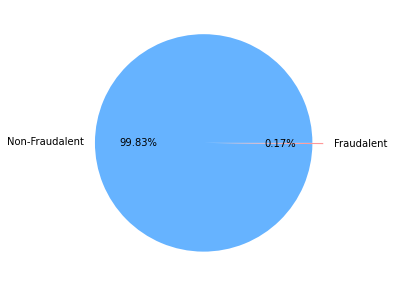

In [11]:
# Plotting percentage of Non-Fraudalent and Fraudalent transactions

plt.figure(figsize=(10,5))

labels = 'Non-Fraudalent', 'Fraudalent'
colors= ['#66b3ff','#ff9999']
plt.pie(data["Class"].value_counts(),labels = labels, explode = (0, 0.1),colors=colors, autopct = '%1.2f%%')

plt.show()

In [12]:
# Counting of Non-Fraudalent and Fraudalent transactions

print("Number of Non-Fraudalent Transaction : ", data["Class"].value_counts()[0])
print("Number of Fraudalent Transaction : ", data["Class"].value_counts()[1])

Number of Non-Fraudalent Transaction :  284315
Number of Fraudalent Transaction :  492


In [13]:
# Percentage of Non-Fraudalent and Fraudalent transactions

print("Number of Non-Fraudalent Transaction : ", round((data["Class"].value_counts()[0]/len(data["Class"]))*100,3), "%")
print("Number of Fraudalent Transaction : ", round((data["Class"].value_counts()[1]/len(data["Class"]))*100,3), "%")

Number of Non-Fraudalent Transaction :  99.827 %
Number of Fraudalent Transaction :  0.173 %


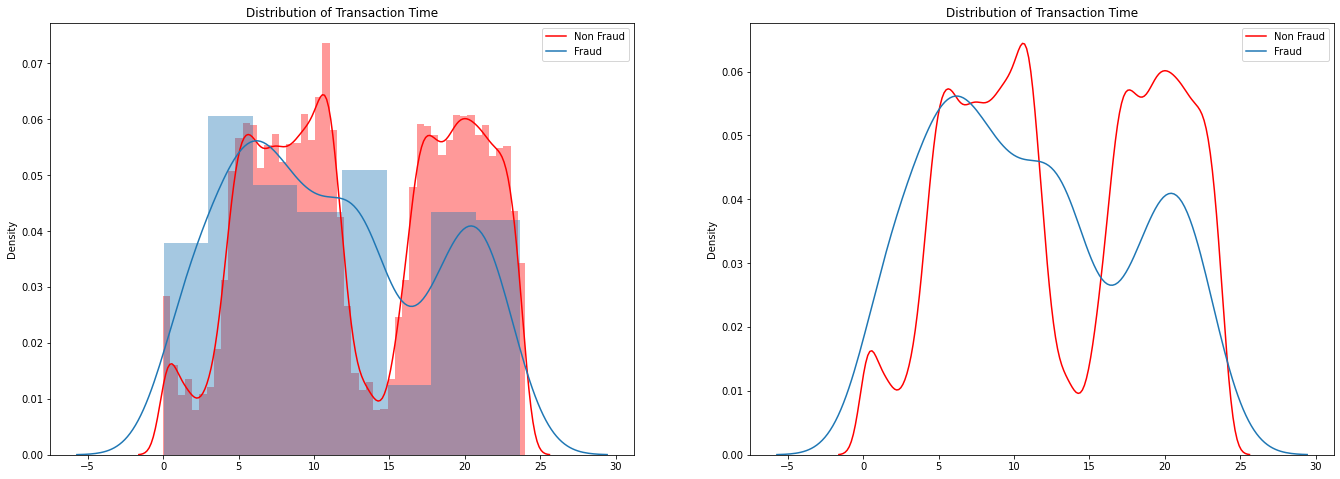

In [14]:
# Time Distribution plot for transactions 

plt.figure(figsize=(23,3))
plt.subplots_adjust(left=None, bottom=3, right=None, top=5, wspace=None, hspace=None)

# with histogram
plt.subplot(1, 2, 1)
plt.title('Distribution of Transaction Time')
sns.distplot(data[data.Class == 0]['Time'].values/(60*60*2),color='red')
sns.distplot(data[data.Class == 1]['Time'].values/(60*60*2))
plt.legend(['Non Fraud','Fraud'])



# without histogram
plt.subplot(1, 2, 2)
plt.title('Distribution of Transaction Time')
sns.distplot(data[data.Class == 0]['Time'].values/(60*60*2),color='red', hist=False)
sns.distplot(data[data.Class == 1]['Time'].values/(60*60*2), hist=False)
plt.legend(['Non Fraud','Fraud'])

plt.show()

#### Inference: Most of the fraudlent transactions are happening in early hours of the day.

In [15]:
# Dropping the Time columns as it is of no use in model building
data = data.drop('Time' , axis=1)
data.shape

(284807, 30)

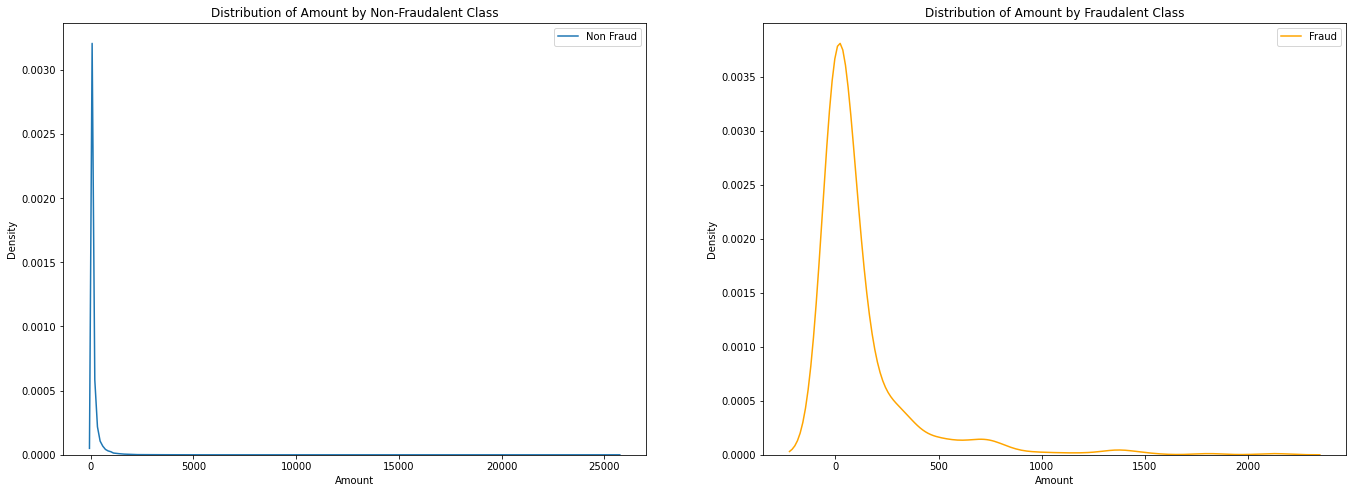

In [16]:
# KDE plot to visualize the distribution of Amount for Non-Fraudalent class as well as Fraudalent Class
plt.figure(figsize=(23,3))
plt.subplots_adjust(left=None, bottom=3, right=None, top=5, wspace=None, hspace=None)

# Non-Fraudalent Class
plt.subplot(1, 2, 1)
sns.kdeplot(data[data.Class == 0]['Amount'])
plt.title('Distribution of Amount by Non-Fraudalent Class')
plt.legend(['Non Fraud'])
plt.xlabel('Amount')
plt.ylabel('Density')



# Fraudalent Class
plt.subplot(1, 2, 2)
sns.kdeplot(data[data.Class == 1]['Amount'],color='orange')
plt.title('Distribution of Amount by Fraudalent Class')
plt.legend(['Fraud'])
plt.xlabel('Amount')
plt.ylabel('Density')

plt.show()

\
**Correlation Heatmap**

---

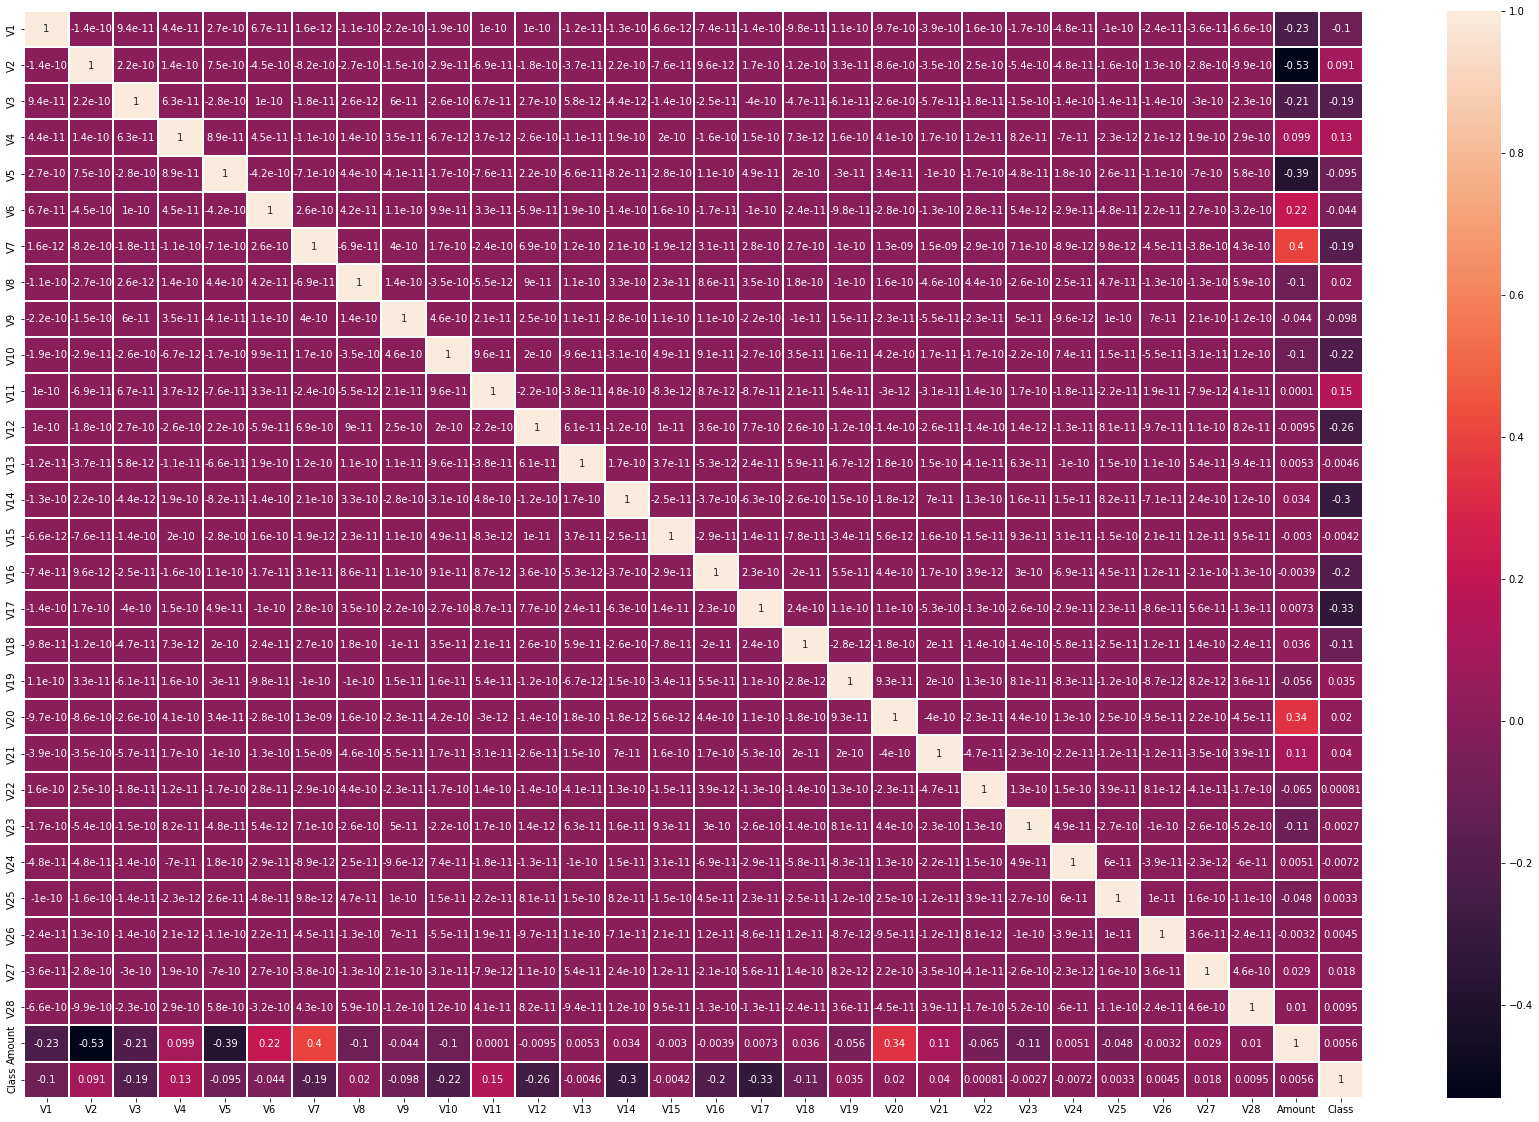

In [17]:
# Plotting Correlation Heatmap

# figure size
plt.figure(figsize=(30,20))

# heatmap
sns.heatmap(data.corr(), annot=True, linewidth=1)
plt.show()

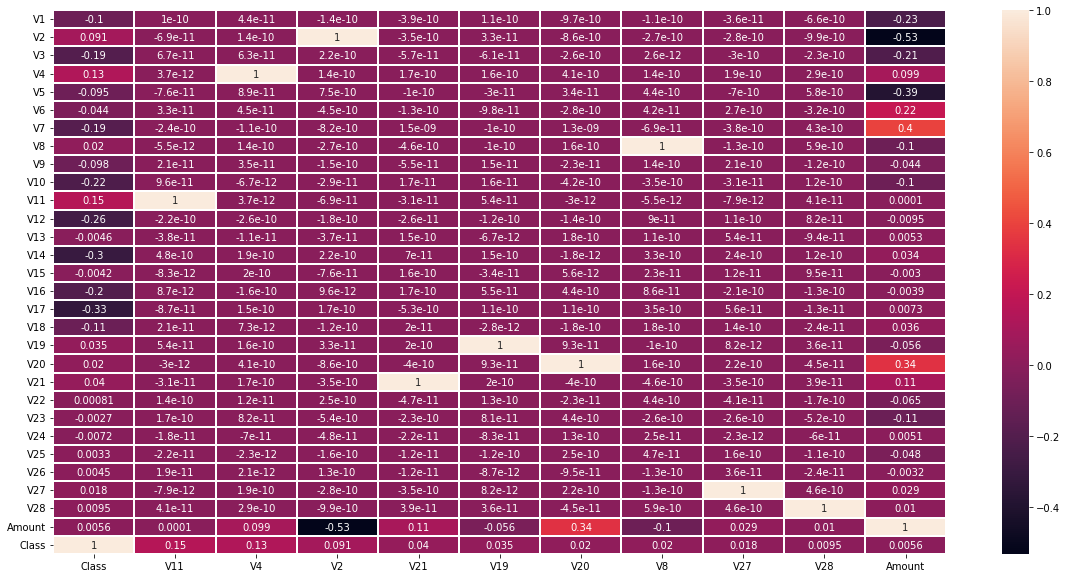

In [18]:
# heatmap of top 10 related variables to target variable

cols = data.columns

# figure size
plt.figure(figsize=(20,10))

# heatmap
sns.heatmap((data[cols].corr().nlargest(11, 'Class')).T , annot=True, linewidth=1)
plt.show()

### 3. Train-Test Split

In [19]:
# Import train-test split

from sklearn.model_selection import train_test_split

In [20]:
# Putting response variable to y
y = data['Class']

# Putting feature variables to X
X = data.drop(['Class'], axis=1)

In [21]:
# Splitting data into train and test set 70:30

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, test_size=0.3, stratify=y, random_state=100)

In [22]:
# Importing StandardScaler

from sklearn.preprocessing import StandardScaler

# 1. Instantiate an object

scaler = StandardScaler()

# 2. Fit on data and transform

X_train['Amount'] = scaler.fit_transform(X_train[['Amount']])

In [23]:
X_train.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
201788,2.023734,-0.429219,-0.691061,-0.201461,-0.162486,0.283718,-0.674694,0.192230,1.124319,-0.037763,0.308648,0.875063,-0.009562,0.116038,0.086537,0.628337,-0.997868,0.482547,0.576077,-0.171390,-0.195207,-0.477813,0.340513,0.059174,-0.431015,-0.297028,-0.000063,-0.046947,-0.342381
179369,-0.145286,0.736735,0.543226,0.892662,0.350846,0.089253,0.626708,-0.049137,-0.732566,0.297692,0.519027,0.041275,-0.690783,0.647121,0.526333,-1.098558,0.511739,0.243984,3.349611,0.206709,-0.124288,-0.263560,-0.110568,-0.434224,-0.509076,0.719784,-0.006357,0.146053,-0.204203
73138,-3.015846,-1.920606,1.229574,0.721577,1.089918,-0.195727,-0.462586,0.919341,-0.612193,-0.966197,1.106534,1.026420,-0.474229,0.641488,-0.430684,-0.631257,0.634633,-0.718062,-0.039929,0.842838,0.274911,-0.319550,0.212891,-0.268792,0.241190,0.318445,-0.100726,-0.365257,0.357610
208679,1.851980,-1.007445,-1.499762,-0.220770,-0.568376,-1.232633,0.248573,-0.539483,-0.813368,0.785431,-0.784316,0.673626,1.428269,0.043937,-0.309507,-1.805728,-0.012118,0.377096,-0.658353,-0.196551,-0.406722,-0.899081,0.137370,0.075894,-0.244027,0.455618,-0.094066,-0.031488,0.361947
206534,2.237844,-0.551513,-1.426515,-0.924369,-0.401734,-1.438232,-0.119942,-0.449263,-0.717258,0.851668,-0.497634,-0.445482,0.324575,0.125543,0.266588,0.802640,0.225312,-1.865494,0.621879,-0.045417,0.050447,0.125601,0.215531,-0.080485,-0.063975,-0.307176,-0.042838,-0.063872,-0.313354


In [24]:
# Transform the test dataset

X_test['Amount'] = scaler.transform(X_test[['Amount']])
X_test.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
49089,1.229452,-0.235478,-0.627166,0.419877,1.797014,4.069573,-0.896223,1.036103,0.745991,-0.147304,-0.850459,0.397845,-0.259849,-0.277065,-0.766810,-0.200946,-0.338122,0.006032,0.477431,-0.057922,-0.170060,-0.288750,-0.130270,1.025935,0.847990,-0.271476,0.060052,0.018104,-0.337614
154704,2.016893,-0.088751,-2.989258,-0.142575,2.675427,3.332289,-0.652336,0.752811,1.962566,-1.025024,1.126976,-2.418093,1.250341,-0.056209,-0.736695,0.014783,1.890249,0.333755,-0.450398,-0.147619,-0.184153,-0.089661,0.087188,0.570679,0.101899,0.620842,-0.048958,-0.042831,-0.318081
67247,0.535093,-1.469185,0.868279,0.385462,-1.439135,0.368118,-0.499370,0.303698,1.042073,-0.437209,1.145725,0.907573,-1.095634,-0.055080,-0.621880,-0.191066,0.311988,-0.478635,0.231159,0.437685,0.028010,-0.384708,-0.128376,0.286638,-0.136700,0.913904,-0.083364,0.052485,0.850667
251657,2.128486,-0.117215,-1.513910,0.166456,0.359070,-0.540072,0.116023,-0.216140,0.680314,0.079977,-1.705327,-0.127579,-0.207945,0.307878,0.213491,0.163032,-0.587029,-0.561292,0.472667,-0.227278,-0.357993,-0.905085,0.223474,-1.075605,-0.188519,0.267672,-0.071733,-0.072238,-0.341521
201903,0.558593,1.587908,-2.368767,5.124413,2.171788,-0.500419,1.059829,-0.254233,-1.959060,0.948915,-0.288169,-1.007647,0.470316,-2.771902,0.221958,0.354333,2.603189,1.092576,0.668084,0.249457,-0.035049,0.271455,0.381606,0.332001,-0.334757,0.448890,0.168585,0.004955,-0.227135


In [26]:
# training set columns

cols = X_train.columns

\
**Checking Skewness**

---

In [27]:
# Checking skewness of all the features

skew_feats = X_train[cols].skew().sort_values(ascending=False)
skewness = pd.DataFrame({"Skew":skew_feats})
skewness.T

,Amount,V28,V7,V21,V6,V10,V4,V26,V9,V11,V19,V13,V22,V18,V15,V25,V24,V27,V16,V20,V14,V12,V3,V5,V1,V17,V2,V23,V8
Skew,19.239637,11.774928,3.582631,2.376015,2.05319,1.017497,0.684764,0.57744,0.529046,0.369545,0.105261,0.064818,-0.174996,-0.278651,-0.312051,-0.438312,-0.555598,-0.779917,-1.127842,-1.658813,-2.02048,-2.327669,-2.395545,-3.167818,-3.336458,-4.181378,-4.980714,-6.0265,-8.585253


In [28]:
# A skewness value greater than 1 or less than -1 indicates a highly skewed distribution

skewness[(skewness["Skew"] < -1) | (skewness["Skew"] > 1)].T

,Amount,V28,V7,V21,V6,V10,V16,V20,V14,V12,V3,V5,V1,V17,V2,V23,V8
Skew,19.239637,11.774928,3.582631,2.376015,2.05319,1.017497,-1.127842,-1.658813,-2.02048,-2.327669,-2.395545,-3.167818,-3.336458,-4.181378,-4.980714,-6.0265,-8.585253


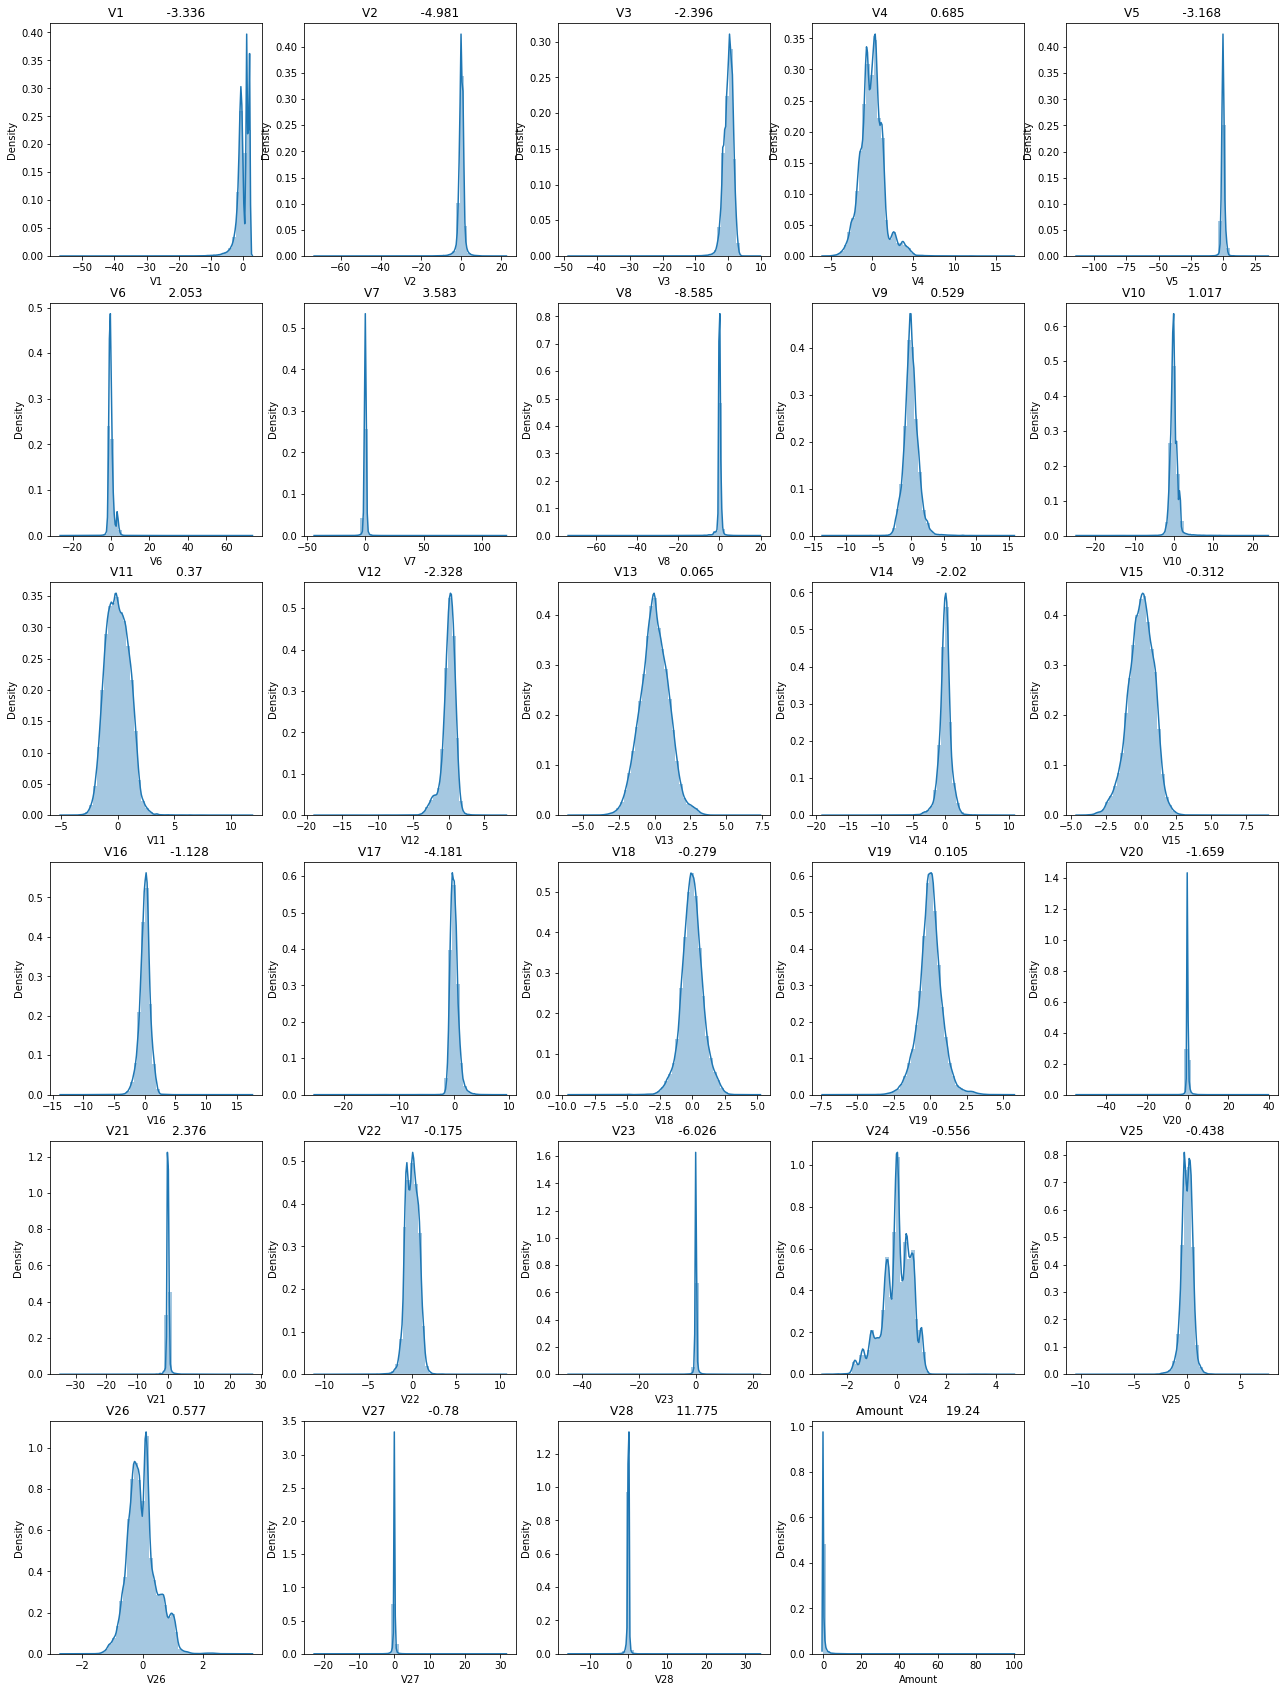

In [29]:
# Plotting the distribution of the variables (skewness) of all the features
n=0
plt.figure(figsize=(22,30))
for cols in X_train.columns :    
    n=n+1
    plt.subplot(6, 5 , n)    
    sns.distplot(X_train[cols])
    plt.title(cols +' '+ '          ' + str(round(X_train[cols].skew(),3)))

#### Inference: There is skewness present in many of the features above. In order to make distribution of a features more Gaussian we are going to perform power transformation.

In [30]:
# Importing PowerTransformer
from sklearn.preprocessing import PowerTransformer

# Instantiate the powertransformer
pt = PowerTransformer(standardize=True, copy=False)

# Fit and transform the PT on training data
X_train[cols] = pt.fit_transform(X_train)

# Transform the test set
X_test[cols] = pt.transform(X_test)

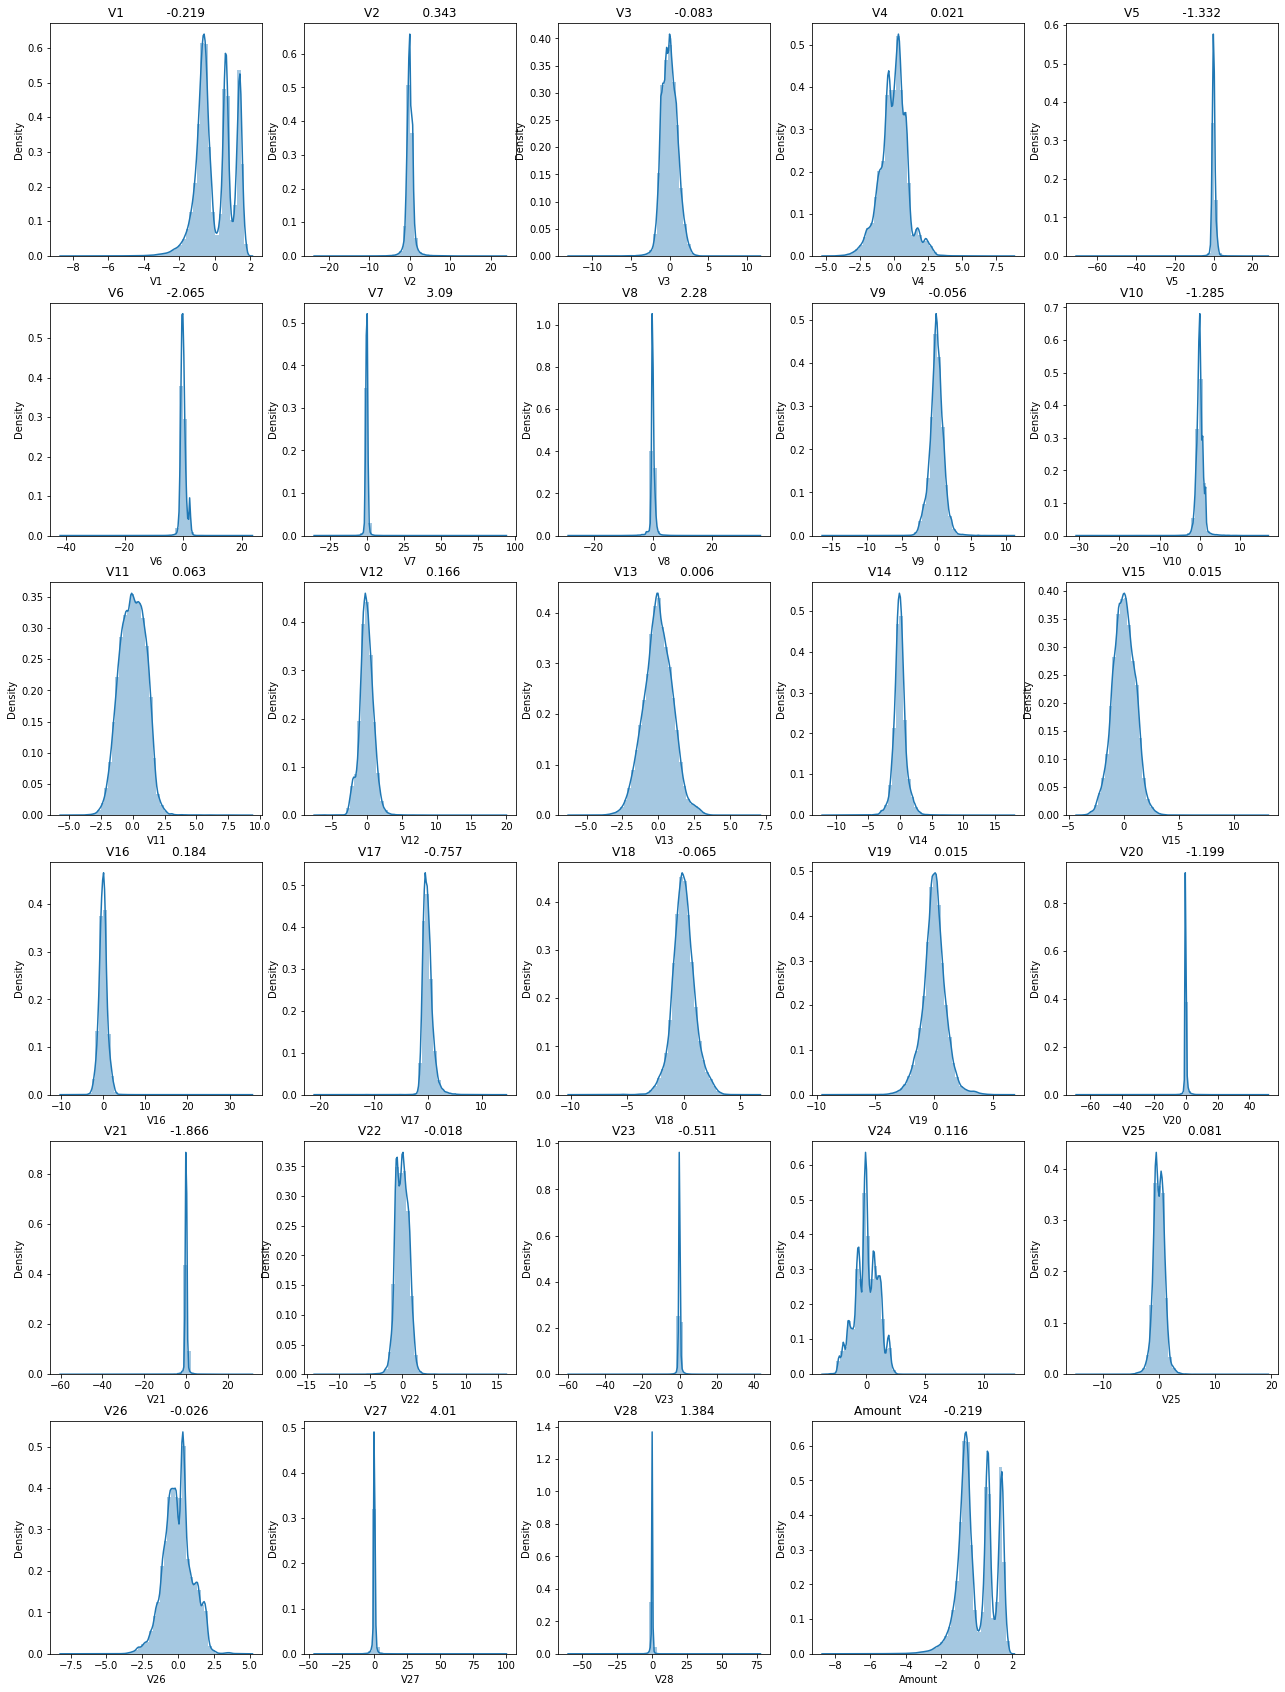

In [31]:
# Plotting the distribution of the variables (skewness) of all the features
n=0
plt.figure(figsize=(22,30))
for cols in X_train.columns :    
    n=n+1
    plt.subplot(6, 5 , n)    
    sns.distplot(X_train[cols])
    plt.title(cols +' '+ '          ' + str(round(X_train[cols].skew(),3)))

#### Inference : We have stabilized the variance of the distribution of features and made them more Gaussian. In other words, we removed the skew in the distribution.

In [32]:
# checking skewness after power-transformation

cols = X_train.columns
skew_feats_pt = X_train[cols].skew().sort_values(ascending=False)
skewness = pd.DataFrame({"Skew":skew_feats_pt})
skewness.T

,V27,V7,V8,V28,V2,V16,V12,V24,V14,V25,V11,V4,V15,V19,V13,V22,V26,V9,V18,V3,V1,Amount,V23,V17,V20,V10,V5,V21,V6
Skew,4.010239,3.090369,2.280287,1.384184,0.343027,0.183682,0.166191,0.11605,0.111713,0.080575,0.063295,0.021224,0.014581,0.014548,0.006493,-0.017814,-0.025913,-0.055823,-0.065134,-0.083494,-0.219268,-0.219268,-0.511358,-0.757285,-1.19921,-1.28487,-1.331951,-1.866231,-2.065467


### 4. Model building / hyperparameter tuning

- While selecting different models on class balanced data, we are not going to build `K-nearest neighbour (KNN)` because KNN works well with smaller datasets because it is a lazy learner. It needs to store all the data and then make a decision only at run time. It includes the computation of distances for a given point with all other points. So if the dataset is large, there will be a lot of processing which require very large amount of resources and it has high computational efficiency. 


- Here We are going to build `XGBoost`, `Random Forest` and `Logistic Regression` models on `imbalanced` data, `SMOTE` balanced data and `ADASYN` balanced data.


### **XGBoost (Imbalanced Data)**

---



---

In [33]:
# XGBoost with some of hyperparameter
%%time

# Importing XGBoost,XGBClassifier and GridSearchCV
import xgboost
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV


# Trying for some of hyperparameters
param_grid = {'learning_rate': [0.2, 0.3, 0.5, 0.6], 
             'n_estimators': [50,100,150] }          


# specify model
xgb_model = xgboost.XGBClassifier(tree_method='gpu_hist', max_bin=16, predictor='gpu_predictor', gpu_id=0)

scorer = metrics.make_scorer(metrics.roc_auc_score,
                             greater_is_better=True,
                             needs_proba=True,
                             needs_threshold=False)

# set up GridSearchCV()
xgb_model_imbalance = GridSearchCV(estimator = xgb_model, 
                         param_grid = param_grid, 
                         scoring= scorer, 
                         cv = 4, 
                         verbose = 1,
                         return_train_score=True)      

# fitting the model
xgb_model_imbalance.fit(X_train, y_train, eval_metric='auc')       

Fitting 4 folds for each of 12 candidates, totalling 48 fits
CPU times: user 51.6 s, sys: 2.75 s, total: 54.3 s
Wall time: 30.9 s


In [34]:
# cv results
cv_results_xgb_imbalance = pd.DataFrame(xgb_model_imbalance.cv_results_)
cv_results_xgb_imbalance

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,mean_train_score,std_train_score
0,1.384777,1.900461,0.050081,0.006324,0.2,50,"{'learning_rate': 0.2, 'n_estimators': 50}",0.976809,0.979413,0.972650,0.989523,0.979599,0.006216,8,0.999959,0.999960,0.999982,0.999952,0.999963,1.111164e-05
1,0.401077,0.003753,0.044020,0.004071,0.2,100,"{'learning_rate': 0.2, 'n_estimators': 100}",0.985956,0.982926,0.971703,0.989544,0.982532,0.006677,3,1.000000,1.000000,1.000000,1.000000,1.000000,4.513833e-08
2,0.524410,0.018785,0.046335,0.004350,0.2,150,"{'learning_rate': 0.2, 'n_estimators': 150}",0.987344,0.982652,0.969985,0.991265,0.982812,0.008008,2,1.000000,1.000000,1.000000,1.000000,1.000000,2.751380e-08
3,0.280157,0.007818,0.047238,0.008401,0.3,50,"{'learning_rate': 0.3, 'n_estimators': 50}",0.973906,0.972139,0.970761,0.993930,0.977684,0.009445,11,0.999999,0.999999,0.999999,0.999999,0.999999,2.204763e-07
4,0.411226,0.013137,0.047630,0.005892,0.3,100,"{'learning_rate': 0.3, 'n_estimators': 100}",0.981297,0.975923,0.970462,0.993674,0.980339,0.008599,7,1.000000,1.000000,1.000000,1.000000,1.000000,3.029851e-08
5,0.478748,0.008414,0.043339,0.001223,0.3,150,"{'learning_rate': 0.3, 'n_estimators': 150}",0.982190,0.977011,0.971388,0.994526,0.981279,0.008549,6,1.000000,1.000000,1.000000,1.000000,1.000000,2.894762e-08
6,0.281092,0.007413,0.041615,0.000686,0.5,50,"{'learning_rate': 0.5, 'n_estimators': 50}",0.988398,0.977200,0.976832,0.986408,0.982209,0.005242,5,1.000000,1.000000,1.000000,1.000000,1.000000,2.900392e-08
7,0.372878,0.014015,0.048529,0.006640,0.5,100,"{'learning_rate': 0.5, 'n_estimators': 100}",0.987934,0.977700,0.976859,0.989965,0.983115,0.005886,1,1.000000,1.000000,1.000000,1.000000,1.000000,3.641717e-08
8,0.441052,0.001752,0.042182,0.001320,0.5,150,"{'learning_rate': 0.5, 'n_estimators': 150}",0.987137,0.976831,0.975602,0.990244,0.982454,0.006348,4,1.000000,1.000000,1.000000,1.000000,1.000000,3.641717e-08
9,0.268617,0.001517,0.044297,0.004188,0.6,50,"{'learning_rate': 0.6, 'n_estimators': 50}",0.984537,0.970204,0.966950,0.988120,0.977453,0.009039,12,1.000000,1.000000,1.000000,1.000000,1.000000,3.029851e-08


In [35]:
# Checking best parameters, best score and best estimator of above XGBoost model

print(xgb_model_imbalance.best_params_)
print(xgb_model_imbalance.best_score_)
print(xgb_model_imbalance.best_estimator_)

{'learning_rate': 0.5, 'n_estimators': 100}
0.9831146379057552
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=0, importance_type=None,
              interaction_constraints='', learning_rate=0.5, max_bin=16,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=4,
              num_parallel_tree=1, predictor='gpu_predictor', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='gpu_hist', validate_parameters=1, verbosity=None)


In [37]:
%%time

# Run for best hyperparameters

param_grid = {"learning_rate": [ 0.01, 0.1, 0.2, 0.3, 0.5],
               "max_depth": [2, 4, 5, 7, 9 ,10],
               "subsample": [0.2, 0.4, 0.5, 0.6, 0.9],
               "min_child_weight": [1, 3, 5, 7, 10],
               "n_estimators": [25, 50, 100]
              }

scorer = metrics.make_scorer(metrics.roc_auc_score,
                             greater_is_better=True,
                             needs_proba=True,
                             needs_threshold=False)

xgb_model_imbalance_fnl = GridSearchCV(estimator = xgb_model, 
                                       param_grid = param_grid, 
                                       scoring= scorer, 
                                       cv = 4, 
                                       verbose = 1,
                                       return_train_score=True)
                    

# fitting the model
xgb_model_imbalance_fnl.fit(X_train, y_train, eval_metric='auc')

Fitting 4 folds for each of 2250 candidates, totalling 9000 fits
CPU times: user 2h 6min 53s, sys: 7min 52s, total: 2h 14min 46s
Wall time: 1h 14s


In [38]:
# cv results
cv_results_xgb_imbalance_fnl = pd.DataFrame(xgb_model_imbalance_fnl.cv_results_)
cv_results_xgb_imbalance_fnl

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_max_depth,param_min_child_weight,param_n_estimators,param_subsample,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,mean_train_score,std_train_score
0,0.206744,0.008877,0.036464,0.000925,0.01,2,1,25,0.2,"{'learning_rate': 0.01, 'max_depth': 2, 'min_c...",0.959939,0.936984,0.958146,0.974572,0.957410,0.013404,1979,0.952922,0.962242,0.969945,0.949018,0.958532,0.008155
1,0.262576,0.009764,0.054281,0.006624,0.01,2,1,25,0.4,"{'learning_rate': 0.01, 'max_depth': 2, 'min_c...",0.958636,0.927248,0.959708,0.973742,0.954834,0.017005,2021,0.948302,0.958760,0.967276,0.948465,0.955701,0.007913
2,0.276034,0.008861,0.057858,0.005210,0.01,2,1,25,0.5,"{'learning_rate': 0.01, 'max_depth': 2, 'min_c...",0.958636,0.927248,0.959854,0.970814,0.954138,0.016233,2046,0.948302,0.958760,0.967639,0.944160,0.954715,0.009164
3,0.264747,0.008333,0.064282,0.015300,0.01,2,1,25,0.6,"{'learning_rate': 0.01, 'max_depth': 2, 'min_c...",0.958636,0.927248,0.959928,0.970814,0.954156,0.016240,2041,0.948302,0.958760,0.967671,0.944160,0.954723,0.009175
4,0.263133,0.021008,0.063095,0.021913,0.01,2,1,25,0.9,"{'learning_rate': 0.01, 'max_depth': 2, 'min_c...",0.958636,0.927248,0.946671,0.970814,0.950842,0.016076,2137,0.948302,0.958760,0.952293,0.944160,0.950879,0.005383
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2245,0.253271,0.008525,0.040021,0.001072,0.5,10,10,100,0.2,"{'learning_rate': 0.5, 'max_depth': 10, 'min_c...",0.967946,0.962124,0.964358,0.988385,0.970703,0.010417,1297,0.975239,0.979278,0.976969,0.971378,0.975716,0.002885
2246,0.288771,0.020803,0.044602,0.002227,0.5,10,10,100,0.4,"{'learning_rate': 0.5, 'max_depth': 10, 'min_c...",0.975465,0.978333,0.962652,0.992324,0.977193,0.010544,553,0.992344,0.987498,0.992416,0.986454,0.989678,0.002727
2247,0.271072,0.007232,0.045758,0.005051,0.5,10,10,100,0.5,"{'learning_rate': 0.5, 'max_depth': 10, 'min_c...",0.969357,0.972411,0.953107,0.987871,0.970687,0.012340,1303,0.995273,0.993013,0.997134,0.996918,0.995584,0.001650
2248,0.281279,0.008193,0.043998,0.000772,0.5,10,10,100,0.6,"{'learning_rate': 0.5, 'max_depth': 10, 'min_c...",0.974430,0.975893,0.960487,0.982723,0.973383,0.008077,1052,0.996693,0.997094,0.998766,0.997224,0.997444,0.000788


In [39]:
# Checking best parameters, best score and best estimator of above XGBoost model for best hyper-parameters

print(xgb_model_imbalance_fnl.best_params_)
print(xgb_model_imbalance_fnl.best_score_)
print(xgb_model_imbalance_fnl.best_estimator_)

{'learning_rate': 0.2, 'max_depth': 5, 'min_child_weight': 10, 'n_estimators': 50, 'subsample': 0.6}
0.9841206077316396
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=0, importance_type=None,
              interaction_constraints='', learning_rate=0.2, max_bin=16,
              max_delta_step=0, max_depth=5, min_child_weight=10, missing=nan,
              monotone_constraints='()', n_estimators=50, n_jobs=4,
              num_parallel_tree=1, predictor='gpu_predictor', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.6,
              tree_method='gpu_hist', validate_parameters=1, verbosity=None)


In [40]:
# Final XGBoost Model for best hyperparameters

xgb_imbalance_final_model = xgboost.XGBClassifier(tree_method='gpu_hist', max_bin=16, predictor='gpu_predictor', gpu_id=0,
                                subsample= 0.6,
                                learning_rate=0.2,
                                max_depth=5,
                                min_child_weight=10,
                                n_estimators=50)

# fitting the model
xgb_imbalance_final_model.fit(X_train, y_train, eval_metric='auc')

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=0, importance_type=None,
              interaction_constraints='', learning_rate=0.2, max_bin=16,
              max_delta_step=0, max_depth=5, min_child_weight=10, missing=nan,
              monotone_constraints='()', n_estimators=50, n_jobs=4,
              num_parallel_tree=1, predictor='gpu_predictor', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.6,
              tree_method='gpu_hist', validate_parameters=1, verbosity=None)

In [41]:
# ROC AUC Score of train-test set

print('ROC AUC on train data by XGBoost =', metrics.roc_auc_score(y_true=y_train,
                                                              y_score=xgb_imbalance_final_model.predict_proba(X_train)[:, 1]))

print('ROC AUC on test data by XGBoost =', metrics.roc_auc_score(y_true=y_test,
                                                             y_score=xgb_imbalance_final_model.predict_proba(X_test)[:, 1]))

ROC AUC on train data by XGBoost = 0.9916587849526739
ROC AUC on test data by XGBoost = 0.9828244799177013


In [42]:
# ROC Curve function

def draw_roc( actual, probs ):
    fpr, tpr, thresholds = metrics.roc_curve( actual, probs,
                                              drop_intermediate = False )
    auc_score = metrics.roc_auc_score( actual, probs )
    plt.figure(figsize=(5, 5))
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic Curve')
    plt.legend(loc="lower right")
    plt.show()

    return None


In [43]:
# Predicting y_pred for train and test sets

y_train_pred_xgb_imb = xgb_imbalance_final_model.predict(X_train)
y_test_pred_xgb_imb = xgb_imbalance_final_model.predict(X_test)

In [44]:
# Predicting y_pred_proba for train and test sets

y_train_pred_proba_xgb_imb = xgb_imbalance_final_model.predict_proba(X_train)[:,1]
y_test_pred_proba_xgb_imb = xgb_imbalance_final_model.predict_proba(X_test)[:,1]

In [45]:
# confusion matrix for train df 
print("Accuracy Score for train_df : ", accuracy_score(y_train, y_train_pred_xgb_imb))
confusion_matrix_train = confusion_matrix(y_train, y_train_pred_xgb_imb)
confusion_matrix_train

Accuracy Score for train_df :  0.9995084368291166


array([[198985,     29],
       [    69,    281]])

In [46]:
# Metrics - Sensitivity, Specificity on train_df

TP1 = confusion_matrix_train[1,1] # true positive 
TN1 = confusion_matrix_train[0,0] # true negatives
FP1 = confusion_matrix_train[0,1] # false positives
FN1 = confusion_matrix_train[1,0] # false negatives

In [47]:
# Sensitivity on train set

sensitivity_train_xgb = TP1 / float(TP1+FN1)
print("Initial sensitivity on train_df : " , sensitivity_train_xgb)

Initial sensitivity on train_df :  0.8028571428571428


In [48]:
# Specificity on train set

specificity_train_xgb = TN1 / float(TN1+FP1)
print("Initial specificity on train_df : " , specificity_train_xgb)

Initial specificity on train_df :  0.999854281608329


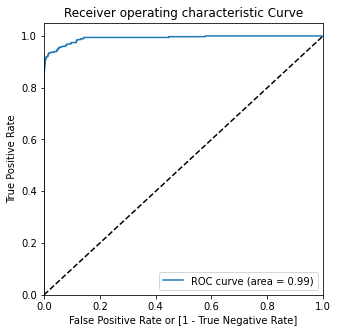

In [49]:
# Plot the ROC curve on train set

draw_roc(y_train, y_train_pred_proba_xgb_imb)

In [50]:
# confusion matrix for test df
print("Accuracy Score for test_df : ",accuracy_score(y_test, y_test_pred_xgb_imb))
confusion_matrix_test = confusion_matrix(y_test, y_test_pred_xgb_imb)
confusion_matrix_test

Accuracy Score for test_df :  0.9991573329588147


array([[56845,    21],
       [   27,    69]])

In [51]:
# Metrics - Sensitivity, Specificity on test_df

TP2 = confusion_matrix_test[1,1] # true positive 
TN2 = confusion_matrix_test[0,0] # true negatives
FP2 = confusion_matrix_test[0,1] # false positives
FN2 = confusion_matrix_test[1,0] # false negatives

In [52]:
# sensitivity on test set

sensitivity_test_xgb = TP2 / float(TP2+FN2)
print("Initial sensitivity on test_df : " , sensitivity_test_xgb)

Initial sensitivity on test_df :  0.71875


In [53]:
# Specificity on test set

specificity_test_xgb = TN2 / float(TN2+FP2)
print("Initial specificity on test_df : " , specificity_test_xgb)

Initial specificity on test_df :  0.999630710793796


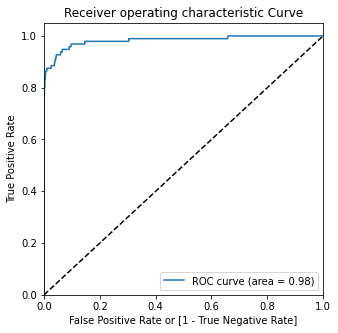

In [54]:
# Plot the ROC curve on test set

draw_roc(y_test, y_test_pred_proba_xgb_imb)

In [55]:
pip install tabulate

In [56]:
# XGboost model on imbalanced data

xgb_imbalanced_result = [['Model', 'Sensitivity', 'Specificity', 'Accuracy', 'ROC AUC'], 
                         ['XGBoost(Imbalanced_data)', sensitivity_test_xgb, specificity_test_xgb, accuracy_score(y_test, y_test_pred_xgb_imb),metrics.roc_auc_score(y_true=y_test, y_score=xgb_imbalance_final_model.predict_proba(X_test)[:, 1])]]

print(tabulate(xgb_imbalanced_result, headers='firstrow', tablefmt='grid'))

+--------------------------+---------------+---------------+------------+-----------+
| Model                    |   Sensitivity |   Specificity |   Accuracy |   ROC AUC |
+==========================+===============+===============+============+===========+
| XGBoost(Imbalanced_data) |       0.71875 |      0.999631 |   0.999157 |  0.982824 |
+--------------------------+---------------+---------------+------------+-----------+



### **RANDOM FOREST (Imbalanced Data)**

---



---

In [57]:
# Importing RandomForestClassifier and HalvingGridSearchCV

from cuml.ensemble import RandomForestClassifier
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV

In [58]:
%%time
# instantiate RandomForest Classifier

rf = RandomForestClassifier(random_state=42)


# Defining parameters for HalvingGridSearchCV

parameters_rf_imbalanced = { 'max_depth' : [1, 2, 5, 10, 20],
                             'min_samples_leaf' : [5, 10, 20, 50],
                             'max_features' : [2, 3, 4, 6 ],
                             'n_estimators' : [10, 30, 50, 100, 200],
                             'min_samples_split' : [2, 4, 5, 7, 9, 10],
                             'bootstrap' :  [True]
                           }


# performing HalvingGridSearchCV on RF Classifier

rf_model_imbalance = HalvingGridSearchCV(estimator=rf,
                                         param_grid=parameters_rf_imbalanced,
                                         cv=4,
                                         verbose=1,
                                         scoring="accuracy"
                                        )



# Fitting Model

rf_model_imbalance.fit(X_train, y_train)

n_iterations: 8
n_required_iterations: 8
n_possible_iterations: 8
min_resources_: 91
max_resources_: 199364
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 2400
n_resources: 91
Fitting 4 folds for each of 2400 candidates, totalling 9600 fits
----------
iter: 1
n_candidates: 800
n_resources: 273
Fitting 4 folds for each of 800 candidates, totalling 3200 fits
----------
iter: 2
n_candidates: 267
n_resources: 819
Fitting 4 folds for each of 267 candidates, totalling 1068 fits
----------
iter: 3
n_candidates: 89
n_resources: 2457
Fitting 4 folds for each of 89 candidates, totalling 356 fits
----------
iter: 4
n_candidates: 30
n_resources: 7371
Fitting 4 folds for each of 30 candidates, totalling 120 fits
----------
iter: 5
n_candidates: 10
n_resources: 22113
Fitting 4 folds for each of 10 candidates, totalling 40 fits
----------
iter: 6
n_candidates: 4
n_resources: 66339
Fitting 4 folds for each of 4 candidates, totalling 16 fits
----------
iter: 7
n_candidates: 2


In [59]:
# cv results
cv_results_rf_model_imbalance = pd.DataFrame(rf_model_imbalance.cv_results_)
cv_results_rf_model_imbalance

,iter,n_resources,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_bootstrap,param_max_depth,param_max_features,param_min_samples_leaf,param_min_samples_split,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,mean_train_score,std_train_score
0,0,91,0.472143,0.769940,0.005550,0.003114,True,1,2,5,2,10,"{'bootstrap': True, 'max_depth': 1, 'max_featu...",NaN,NaN,NaN,NaN,NaN,NaN,1802,NaN,NaN,NaN,NaN,NaN,NaN
1,0,91,0.045291,0.007218,0.003618,0.000280,True,1,2,5,2,30,"{'bootstrap': True, 'max_depth': 1, 'max_featu...",NaN,NaN,NaN,NaN,NaN,NaN,2394,NaN,NaN,NaN,NaN,NaN,NaN
2,0,91,0.059686,0.008097,0.003196,0.000334,True,1,2,5,2,50,"{'bootstrap': True, 'max_depth': 1, 'max_featu...",NaN,NaN,NaN,NaN,NaN,NaN,2395,NaN,NaN,NaN,NaN,NaN,NaN
3,0,91,0.118660,0.010603,0.003195,0.000316,True,1,2,5,2,100,"{'bootstrap': True, 'max_depth': 1, 'max_featu...",NaN,NaN,NaN,NaN,NaN,NaN,2396,NaN,NaN,NaN,NaN,NaN,NaN
4,0,91,0.163513,0.006777,0.004313,0.001287,True,1,2,5,2,200,"{'bootstrap': True, 'max_depth': 1, 'max_featu...",NaN,NaN,NaN,NaN,NaN,NaN,2397,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3597,6,66339,0.245265,0.004283,0.008276,0.000802,True,5,2,5,2,100,"{'bootstrap': True, 'max_depth': 5, 'max_featu...",0.999216,0.998734,0.999337,0.999337,0.999156,0.000249,15,0.999256,0.999477,0.999477,0.999297,0.999377,0.000101
3598,6,66339,0.043536,0.001971,0.006160,0.000379,True,5,2,5,2,10,"{'bootstrap': True, 'max_depth': 5, 'max_featu...",0.999337,0.998915,0.999337,0.999337,0.999231,0.000183,5,0.999377,0.999578,0.999457,0.999437,0.999462,0.000073
3599,6,66339,0.044451,0.001210,0.006874,0.000524,True,5,2,5,4,10,"{'bootstrap': True, 'max_depth': 5, 'max_featu...",0.999337,0.998915,0.999337,0.999337,0.999231,0.000183,5,0.999377,0.999578,0.999457,0.999437,0.999462,0.000073
3600,7,199017,0.081359,0.005659,0.013724,0.000444,True,5,2,5,2,10,"{'bootstrap': True, 'max_depth': 5, 'max_featu...",0.999337,0.999276,0.999457,0.999477,0.999387,0.000083,1,0.999410,0.999511,0.999417,0.999417,0.999439,0.000042


In [60]:
# Checking best parameters, best score and best estimator of above RandomForest model

print(rf_model_imbalance.best_params_)
print(rf_model_imbalance.best_score_)
print(rf_model_imbalance.best_estimator_)

{'bootstrap': True, 'max_depth': 5, 'max_features': 2, 'min_samples_leaf': 5, 'min_samples_split': 2, 'n_estimators': 10}
0.9993869839610886
RandomForestClassifier()


In [62]:
## Final Model for Random Forest


rf_model_imbalance_final = RandomForestClassifier(random_state=42, 
                                                  max_depth=5, 
                                                  max_features= 2, 
                                                  n_estimators=10,
                                                  min_samples_leaf= 5,
                                                  min_samples_split= 2,
                                                  bootstrap= True
                                                  )


rf_model_imbalance_final.fit(X_train, y_train)

RandomForestClassifier()

In [63]:
# ROC AUC Score of train-test set

print('ROC AUC on train data by Random Forest =', metrics.roc_auc_score(y_true=y_train,
                                                              y_score=rf_model_imbalance_final.predict_proba(X_train)[:, 1]))

print('ROC AUC on test data by Random Forest =', metrics.roc_auc_score(y_true=y_test,
                                                             y_score=rf_model_imbalance_final.predict_proba(X_test)[:, 1]))

ROC AUC on train data by Random Forest = 0.9822456280893375
ROC AUC on test data by Random Forest = 0.9703773637440063


In [64]:
# Predicting y_pred for train and test sets

y_train_pred_rf_imb = rf_model_imbalance_final.predict(X_train)
y_test_pred_rf_imb = rf_model_imbalance_final.predict(X_test)

In [65]:
# Predicting y_pred_proba for train and test sets

y_train_pred_proba_rf_imb = rf_model_imbalance_final.predict_proba(X_train)[:,1]
y_test_pred_proba_rf_imb = rf_model_imbalance_final.predict_proba(X_test)[:,1]

In [66]:
# confusion matrix for train df for RandomForest

print("Accuracy Score for train_df : ", accuracy_score(y_train, y_train_pred_rf_imb))
confusion_matrix_train_rf = confusion_matrix(y_train, y_train_pred_rf_imb)
confusion_matrix_train_rf

Accuracy Score for train_df :  0.9994231656668204


array([[198986,     28],
       [    87,    263]])

In [67]:
# Metrics - Sensitivity, Specificity

TP1rf1 = confusion_matrix_train_rf[1,1] # true positive 
TN1rf1 = confusion_matrix_train_rf[0,0] # true negatives
FP1rf1 = confusion_matrix_train_rf[0,1] # false positives
FN1rf1 = confusion_matrix_train_rf[1,0] # false negatives

In [68]:
# sensitivity on train df for RandomForest

sensitivity_train_rf = TP1rf1 / float(TP1rf1+FN1rf1)
print("Initial sensitivity on train_df : " , sensitivity_train_rf)

Initial sensitivity on train_df :  0.7514285714285714


In [69]:
# specificity on train for RandomForest

specificity_train_rf = TN1rf1 / float(TN1rf1+FP1rf1)
print("Initial specificity on train_df : " , specificity_train_rf)

Initial specificity on train_df :  0.9998593063804556


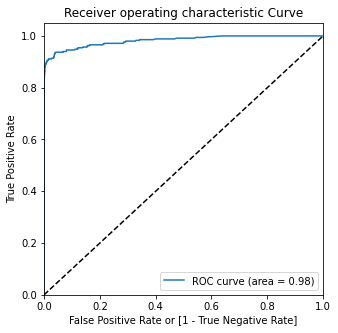

In [70]:
# Plot the ROC curve on train set

draw_roc(y_train, y_train_pred_proba_rf_imb)

In [71]:
# confusion matrix for test df
print("Accuracy Score for test_df : ",accuracy_score(y_test, y_test_pred_rf_imb))
confusion_matrix_test_rf = confusion_matrix(y_test, y_test_pred_rf_imb)
confusion_matrix_test_rf

Accuracy Score for test_df :  0.9991222218320986


array([[56847,    19],
       [   31,    65]])

In [72]:
# Metrics - Sensitivity, Specificity for RandomForest

TP2rf2 = confusion_matrix_test_rf[1,1] # true positive 
TN2rf2 = confusion_matrix_test_rf[0,0] # true negatives
FP2rf2 = confusion_matrix_test_rf[0,1] # false positives
FN2rf2 = confusion_matrix_test_rf[1,0] # false negatives

In [73]:
# sensitivity on test for RandomForest

sensitivity_test_rf = TP2rf2 / float(TP2rf2+FN2rf2)
print("Initial sensitivity on test_df : " , sensitivity_test_rf)

Initial sensitivity on test_df :  0.6770833333333334


In [74]:
# specificity on test for RandomForest

specificity_test_rf = TN2rf2 / float(TN2rf2+FP2rf2)
print("Initial specificity on test_df : " , specificity_test_rf)

Initial specificity on test_df :  0.9996658811943868


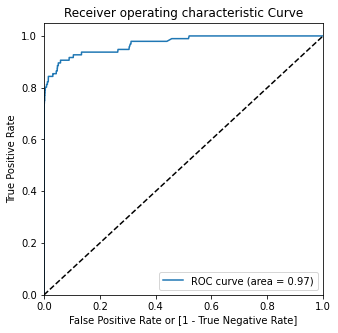

In [75]:
# Plot the ROC curve on test set

draw_roc(y_test, y_test_pred_proba_rf_imb)

In [76]:
# Random forest on imbalanced data

rf_imbalanced_result = [['Model', 'Sensitivity', 'Specificity', 'Accuracy', 'ROC AUC'], 
                        ['Random Forest(Imbalanced_data)', sensitivity_test_rf, specificity_test_rf, accuracy_score(y_test, y_test_pred_rf_imb), metrics.roc_auc_score(y_true=y_test,y_score=rf_model_imbalance_final.predict_proba(X_test)[:, 1])]]

print(tabulate(rf_imbalanced_result, headers='firstrow', tablefmt='grid'))

+--------------------------------+---------------+---------------+------------+-----------+
| Model                          |   Sensitivity |   Specificity |   Accuracy |   ROC AUC |
+================================+===============+===============+============+===========+
| Random Forest(Imbalanced_data) |      0.677083 |      0.999666 |   0.999122 |  0.970377 |
+--------------------------------+---------------+---------------+------------+-----------+



### **Logistic Regression (Imbalanced Data)**

---



---

In [77]:
# Importing scikit logistic regression
from sklearn.linear_model import LogisticRegression

In [78]:
%%time

# Specify parameters
params_LR_imbalanced = {"C": [0.01, 0.1, 1, 10, 50, 100]}

LR = LogisticRegression()

# Specifing GridSearchCV
LR_model_imbalanced = GridSearchCV(estimator = LR,
                        param_grid = params_LR_imbalanced, 
                        scoring= 'roc_auc', 
                        cv = 4, 
                        verbose = 1,
                        return_train_score=True) 

# Fitting the model
LR_model_imbalanced.fit(X_train, y_train)

Fitting 4 folds for each of 6 candidates, totalling 24 fits
CPU times: user 46 s, sys: 53.2 s, total: 1min 39s
Wall time: 25.6 s


In [79]:
# results of grid search CV
cv_results_LR_model_imbalanced = pd.DataFrame(LR_model_imbalanced.cv_results_)
cv_results_LR_model_imbalanced

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,mean_train_score,std_train_score
0,0.627574,0.018453,0.034864,0.005040,0.01,{'C': 0.01},0.981639,0.987412,0.973986,0.995607,0.984661,0.007913,1,0.988039,0.986966,0.988445,0.983445,0.986724,0.001968
1,0.986242,0.166149,0.031027,0.000679,0.1,{'C': 0.1},0.982374,0.984412,0.970249,0.994393,0.982857,0.008584,2,0.986811,0.986449,0.987558,0.982452,0.985817,0.001984
2,0.966149,0.072198,0.032493,0.002135,1,{'C': 1},0.982657,0.982938,0.969400,0.993647,0.982161,0.008597,3,0.986194,0.985993,0.987180,0.982022,0.985347,0.001972
3,0.941887,0.047699,0.032031,0.002694,10,{'C': 10},0.982683,0.982730,0.969301,0.993546,0.982065,0.008596,4,0.986113,0.985925,0.987128,0.981965,0.985283,0.001969
4,0.961543,0.008548,0.030585,0.000805,50,{'C': 50},0.982688,0.982712,0.969294,0.993536,0.982057,0.008595,5,0.986105,0.985919,0.987124,0.981960,0.985277,0.001969
5,0.966504,0.048494,0.032610,0.002120,100,{'C': 100},0.982687,0.982710,0.969293,0.993535,0.982056,0.008595,6,0.986104,0.985918,0.987124,0.981959,0.985276,0.001969


In [80]:
# Checking best parameters, best score and best estimator of above RandomForest model

print(LR_model_imbalanced.best_params_)
print(LR_model_imbalanced.best_score_)
print(LR_model_imbalanced.best_estimator_)

{'C': 0.01}
0.9846611526499927
LogisticRegression(C=0.01)


In [81]:
## Final Model for Logistic Regression

# Instantiate the model with best C
LR_model_imbalanced_fnl = LogisticRegression(C=0.01)

# Fit the model on the train set
LR_model_imbalanced_final = LR_model_imbalanced_fnl.fit(X_train, y_train)

In [82]:
# ROC AUC Score of train-test set

print('ROC AUC on train data by Logistic Regression =', metrics.roc_auc_score(y_true=y_train,
                                                              y_score=LR_model_imbalanced_final.predict_proba(X_train)[:, 1]))

print('ROC AUC on test data by Logistic Regression =', metrics.roc_auc_score(y_true=y_test,
                                                             y_score=LR_model_imbalanced_final.predict_proba(X_test)[:, 1]))

ROC AUC on train data by Logistic Regression = 0.9865954871803706
ROC AUC on test data by Logistic Regression = 0.9662094880948194


In [83]:
# Predicting y_pred for train and test sets

y_train_pred_LR_imb = LR_model_imbalanced_final.predict(X_train)
y_test_pred_LR_imb = LR_model_imbalanced_final.predict(X_test)

In [84]:
# Predicting y_pred_proba for train and test sets
y_train_pred_proba_LR_imb = LR_model_imbalanced_final.predict_proba(X_train)[:,1]
y_test_pred_proba_LR_imb = LR_model_imbalanced_final.predict_proba(X_test)[:,1]

In [85]:
# confusion matrix for train df for Logistic Regression

print("Accuracy Score for train_df : ", accuracy_score(y_train, y_train_pred_LR_imb))
confusion_matrix_train_LR = confusion_matrix(y_train, y_train_pred_LR_imb)
confusion_matrix_train_LR

Accuracy Score for train_df :  0.9993077988001846


array([[198995,     19],
       [   119,    231]])

In [86]:
# Metrics - Sensitivity, Specificity

TP1Lr1 = confusion_matrix_train_LR[1,1] # true positive 
TN1Lr1 = confusion_matrix_train_LR[0,0] # true negatives
FP1Lr1 = confusion_matrix_train_LR[0,1] # false positives
FN1Lr1 = confusion_matrix_train_LR[1,0] # false negatives

In [87]:
# sensitivity on train df for Logistic Regression

sensitivity_train_LR = TP1Lr1 / float(TP1Lr1+FN1Lr1)
print("Initial sensitivity on train_df : " , sensitivity_train_LR)

Initial sensitivity on train_df :  0.66


In [88]:
# specificity on train for Logistic Regression

specificity_train_LR = TN1Lr1 / float(TN1Lr1+FP1Lr1)
print("Initial specificity on train_df : " , specificity_train_LR)

Initial specificity on train_df :  0.999904529329595


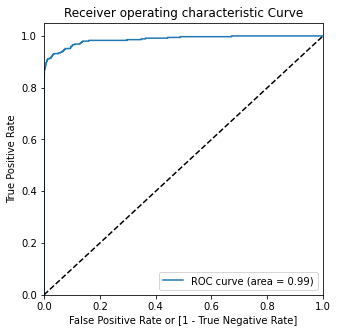

In [89]:
# Plot the ROC curve on train set

draw_roc(y_train, y_train_pred_proba_LR_imb)

In [90]:
# confusion matrix for test df
print("Accuracy Score for test_df : ",accuracy_score(y_test, y_test_pred_LR_imb))
confusion_matrix_test_LR = confusion_matrix(y_test, y_test_pred_LR_imb)
confusion_matrix_test_LR

Accuracy Score for test_df :  0.9989993328885924


array([[56851,    15],
       [   42,    54]])

In [91]:
# Metrics - Sensitivity, Specificity for Logistic Regression

TP2Lr2 = confusion_matrix_test_LR[1,1] # true positive 
TN2Lr2 = confusion_matrix_test_LR[0,0] # true negatives
FP2Lr2 = confusion_matrix_test_LR[0,1] # false positives
FN2Lr2 = confusion_matrix_test_LR[1,0] # false negatives

In [92]:
# sensitivity on test for Logistic Regression

sensitivity_test_LR = TP2Lr2 / float(TP2Lr2+FN2Lr2)
print("Initial sensitivity on test_df : " , sensitivity_test_LR)

Initial sensitivity on test_df :  0.5625


In [93]:
# specificity on test for Logistic Regression

specificity_test_LR = TN2Lr2 / float(TN2Lr2+FP2Lr2)
print("Initial specificity on test_df : " , specificity_test_LR)

Initial specificity on test_df :  0.9997362219955686


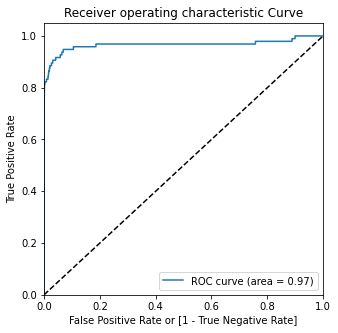

In [94]:
# Plot the ROC curve on test set

draw_roc(y_test, y_test_pred_proba_LR_imb)

In [95]:
# Logistic Regression on Imbalanced data

LR_imbalanced_result = [['Model', 'Sensitivity', 'Specificity', 'Accuracy', 'ROC AUC'], 
         ['Logistic Regression (Imbalanced_data)', sensitivity_test_LR, specificity_test_LR, accuracy_score(y_test, y_test_pred_LR_imb),metrics.roc_auc_score(y_true=y_test,y_score=LR_model_imbalanced_final.predict_proba(X_test)[:, 1])]]

print(tabulate(LR_imbalanced_result, headers='firstrow', tablefmt='grid'))

+---------------------------------------+---------------+---------------+------------+-----------+
| Model                                 |   Sensitivity |   Specificity |   Accuracy |   ROC AUC |
+=======================================+===============+===============+============+===========+
| Logistic Regression (Imbalanced_data) |        0.5625 |      0.999736 |   0.998999 |  0.966209 |
+---------------------------------------+---------------+---------------+------------+-----------+


#### Metrics for XGBoost, Random Forest and Logistic Regression on class imbalanced data

In [96]:
# Metrics on XGBoost, Random Forest and Logistic Regression on imbalanced data

All_model_imbalanced_result = [['Model', 'Sensitivity', 'Specificity', 'Accuracy', 'ROC AUC'], 
                               ['XGBoost (Imbalanced_data)', sensitivity_test_xgb, specificity_test_xgb, accuracy_score(y_test, y_test_pred_xgb_imb),metrics.roc_auc_score(y_true=y_test, y_score=xgb_imbalance_final_model.predict_proba(X_test)[:, 1])],
                               ['Random Forest (Imbalanced_data)', sensitivity_test_rf, specificity_test_rf, accuracy_score(y_test, y_test_pred_rf_imb), metrics.roc_auc_score(y_true=y_test,y_score=rf_model_imbalance_final.predict_proba(X_test)[:, 1])],
                               ['Logistic Regression (Imbalanced_data)', sensitivity_test_LR, specificity_test_LR, accuracy_score(y_test, y_test_pred_LR_imb), metrics.roc_auc_score(y_true=y_test,y_score=LR_model_imbalanced_final.predict_proba(X_test)[:, 1])]]

print(tabulate(All_model_imbalanced_result, headers='firstrow', tablefmt='grid'))

+---------------------------------------+---------------+---------------+------------+-----------+
| Model                                 |   Sensitivity |   Specificity |   Accuracy |   ROC AUC |
+=======================================+===============+===============+============+===========+
| XGBoost (Imbalanced_data)             |      0.71875  |      0.999631 |   0.999157 |  0.982824 |
+---------------------------------------+---------------+---------------+------------+-----------+
| Random Forest (Imbalanced_data)       |      0.677083 |      0.999666 |   0.999122 |  0.970377 |
+---------------------------------------+---------------+---------------+------------+-----------+
| Logistic Regression (Imbalanced_data) |      0.5625   |      0.999736 |   0.998999 |  0.966209 |
+---------------------------------------+---------------+---------------+------------+-----------+


#### Inference:
- We are going to Evaluate Model on `Sensitivity` and `ROC AUC`.
- Sensitivity: The ability of a model to correctly identify transactions as Fraudulent.
- From all the models that we ran on Imbalanced data `XGBoost` has highest `Sensitivity:0.72` and `ROC AUC:0.98`.



## SMOTE (Synthetic Minority Oversampling Technique)

---



---

In [97]:
# Importing SMOTE
from imblearn.over_sampling import SMOTE

In [98]:
# treating class imbalance

# Create SMOTE instance
sm = SMOTE(random_state=42)

# Fit and resample imbalanced data
X_train_sm, y_train_sm = sm.fit_resample(X_train, y_train)

In [99]:
# Before and after shape of training set after doing SMOTE oversampling

print('Before SMOTE oversampling X_train shape=',X_train.shape)
print('After SMOTE oversampling X_train shape=',X_train_sm.shape)

Before SMOTE oversampling X_train shape= (199364, 29)
After SMOTE oversampling X_train shape= (398028, 29)


In [100]:
import collections

# Befor oversampling class distribution
print('Before SMOTE Over-sampling class distribution:-',collections.Counter(y_train))
# after oversampling class distribution 
print('After SMOTE Over-sampling class distribution:-',collections.Counter(y_train_sm))

Before SMOTE Over-sampling class distribution:- Counter({0: 199014, 1: 350})
After SMOTE Over-sampling class distribution:- Counter({0: 199014, 1: 199014})



### **XGBoost (SMOTE BALANCED)**

---



---

In [101]:
%%time
# XGBoost with some of hyperparameter

# Trying for some of hyperparameters
param_grid = {'learning_rate': [0.2, 0.3, 0.5, 0.6], 
             'n_estimators': [50,100,150] }          


# specify model
xgb_model_smote = xgboost.XGBClassifier(tree_method='gpu_hist', max_bin=16, predictor='gpu_predictor', gpu_id=0)

scorer = metrics.make_scorer(metrics.roc_auc_score,
                             greater_is_better=True,
                             needs_proba=True,
                             needs_threshold=False)

# set up GridSearchCV()
xgb_model_smote_bal = GridSearchCV(estimator = xgb_model_smote, 
                                   param_grid = param_grid, 
                                   scoring= scorer, 
                                   cv = 4, 
                                   verbose = 1,
                                   return_train_score=True)      

# fitting the model
xgb_model_smote_bal.fit(X_train_sm, y_train_sm, eval_metric='auc')

Fitting 4 folds for each of 12 candidates, totalling 48 fits
CPU times: user 1min 24s, sys: 2.33 s, total: 1min 27s
Wall time: 47.4 s


In [102]:
# cv results
cv_results_xgb_smote = pd.DataFrame(xgb_model_smote_bal.cv_results_)
cv_results_xgb_smote

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,mean_train_score,std_train_score
0,0.516006,0.072371,0.070252,0.000459,0.2,50,"{'learning_rate': 0.2, 'n_estimators': 50}",0.999931,0.999922,0.999952,0.999911,0.999929,0.000015,12,0.999950,0.999957,0.999959,0.999959,0.999956,3.880005e-06
1,0.708339,0.005150,0.072199,0.002001,0.2,100,"{'learning_rate': 0.2, 'n_estimators': 100}",0.999996,0.999977,0.999981,0.999973,0.999982,0.000009,10,0.999997,0.999997,0.999998,0.999999,0.999998,9.151461e-07
2,0.929016,0.003763,0.071773,0.001356,0.2,150,"{'learning_rate': 0.2, 'n_estimators': 150}",1.000000,0.999991,0.999984,0.999982,0.999989,0.000007,5,1.000000,1.000000,1.000000,1.000000,1.000000,4.584284e-08
3,0.475161,0.003493,0.072097,0.001757,0.3,50,"{'learning_rate': 0.3, 'n_estimators': 50}",0.999971,0.999961,0.999974,0.999956,0.999966,0.000007,11,0.999986,0.999991,0.999988,0.999989,0.999989,1.971995e-06
4,0.700575,0.006332,0.074231,0.004196,0.3,100,"{'learning_rate': 0.3, 'n_estimators': 100}",0.999999,0.999988,0.999980,0.999981,0.999987,0.000008,7,1.000000,1.000000,1.000000,1.000000,1.000000,9.822624e-09
5,0.899148,0.006989,0.071462,0.001434,0.3,150,"{'learning_rate': 0.3, 'n_estimators': 150}",1.000000,0.999989,0.999981,0.999984,0.999989,0.000007,6,1.000000,1.000000,1.000000,1.000000,1.000000,4.943824e-10
6,0.478486,0.002042,0.068692,0.000652,0.5,50,"{'learning_rate': 0.5, 'n_estimators': 50}",0.999992,0.999987,0.999985,0.999979,0.999986,0.000005,9,0.999999,1.000000,1.000000,1.000000,1.000000,1.705456e-07
7,0.678732,0.005324,0.069500,0.000943,0.5,100,"{'learning_rate': 0.5, 'n_estimators': 100}",0.999998,0.999993,0.999985,0.999981,0.999989,0.000007,4,1.000000,1.000000,1.000000,1.000000,1.000000,4.300917e-10
8,0.849310,0.007177,0.071936,0.000876,0.5,150,"{'learning_rate': 0.5, 'n_estimators': 150}",1.000000,0.999995,0.999986,0.999982,0.999991,0.000007,1,1.000000,1.000000,1.000000,1.000000,1.000000,1.440333e-10
9,0.479015,0.005268,0.071410,0.002135,0.6,50,"{'learning_rate': 0.6, 'n_estimators': 50}",0.999997,0.999986,0.999981,0.999980,0.999986,0.000007,8,1.000000,1.000000,1.000000,1.000000,1.000000,9.825272e-08


In [103]:
# Checking best parameters, best score and best estimator of above XGBoost model on SMOTE class balanced data

print(xgb_model_smote_bal.best_params_)
print(xgb_model_smote_bal.best_score_)
print(xgb_model_smote_bal.best_estimator_)

{'learning_rate': 0.5, 'n_estimators': 150}
0.9999907274480048
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=0, importance_type=None,
              interaction_constraints='', learning_rate=0.5, max_bin=16,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=150, n_jobs=4,
              num_parallel_tree=1, predictor='gpu_predictor', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='gpu_hist', validate_parameters=1, verbosity=None)


In [104]:
%%time

# Run for best hyperparameters

param_grid = {"learning_rate": [ 0.01, 0.1, 0.2, 0.3],
               "max_depth": [2, 4, 5, 7, 9 ,10],
               "subsample": [0.2, 0.4, 0.5, 0.6, 0.9],
               "min_child_weight": [1, 3, 5, 7, 10],
               "n_estimators": [25, 50, 100]
              }

scorer = metrics.make_scorer(metrics.roc_auc_score,
                             greater_is_better=True,
                             needs_proba=True,
                             needs_threshold=False)

xgb_model_smote_bal_fnl = GridSearchCV(estimator = xgb_model_smote, 
                                       param_grid = param_grid, 
                                       scoring= scorer, 
                                       cv = 4, 
                                       verbose = 1,
                                       return_train_score=True)
                    
# fitting the model                    
xgb_model_smote_bal_fnl.fit(X_train_sm, y_train_sm, eval_metric='auc')

Fitting 4 folds for each of 1800 candidates, totalling 7200 fits
CPU times: user 3h 6min 10s, sys: 5min 57s, total: 3h 12min 7s
Wall time: 1h 36min 16s


In [105]:
# cv results
cv_results_xgb_smote_fnl = pd.DataFrame(xgb_model_smote_bal_fnl.cv_results_)
cv_results_xgb_smote_fnl

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_max_depth,param_min_child_weight,param_n_estimators,param_subsample,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,mean_train_score,std_train_score
0,0.326469,0.019257,0.063411,0.002259,0.01,2,1,25,0.2,"{'learning_rate': 0.01, 'max_depth': 2, 'min_c...",0.973604,0.974532,0.973603,0.974352,0.974023,0.000424,1776,0.974470,0.974204,0.973695,0.973820,0.974047,3.078629e-04
1,0.303509,0.021392,0.065305,0.008059,0.01,2,1,25,0.4,"{'learning_rate': 0.01, 'max_depth': 2, 'min_c...",0.972698,0.974037,0.973888,0.974377,0.973750,0.000633,1786,0.973696,0.973801,0.973936,0.973821,0.973813,8.512724e-05
2,0.294336,0.003773,0.062070,0.001692,0.01,2,1,25,0.5,"{'learning_rate': 0.01, 'max_depth': 2, 'min_c...",0.972806,0.974622,0.973746,0.974334,0.973877,0.000694,1781,0.973857,0.974299,0.973784,0.973746,0.973921,2.216802e-04
3,0.297935,0.005662,0.062309,0.001139,0.01,2,1,25,0.6,"{'learning_rate': 0.01, 'max_depth': 2, 'min_c...",0.972416,0.974555,0.971294,0.974368,0.973158,0.001364,1791,0.973437,0.974211,0.971400,0.973772,0.973205,1.077545e-03
4,0.302079,0.010740,0.060950,0.000914,0.01,2,1,25,0.9,"{'learning_rate': 0.01, 'max_depth': 2, 'min_c...",0.972438,0.974001,0.971436,0.973948,0.972955,0.001079,1796,0.973451,0.973749,0.971549,0.973332,0.973020,8.627822e-04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1795,0.661808,0.002955,0.067630,0.000326,0.3,10,10,100,0.2,"{'learning_rate': 0.3, 'max_depth': 10, 'min_c...",0.999957,0.999919,0.999985,0.999963,0.999956,0.000024,341,0.999966,0.999968,0.999978,0.999975,0.999972,4.943749e-06
1796,0.716688,0.006986,0.074369,0.004447,0.3,10,10,100,0.4,"{'learning_rate': 0.3, 'max_depth': 10, 'min_c...",0.999988,0.999968,0.999984,0.999980,0.999980,0.000008,151,0.999989,0.999990,0.999990,0.999994,0.999991,1.944689e-06
1797,0.734850,0.004354,0.067319,0.000574,0.3,10,10,100,0.5,"{'learning_rate': 0.3, 'max_depth': 10, 'min_c...",0.999987,0.999969,0.999985,0.999987,0.999982,0.000007,127,0.999992,0.999993,0.999994,0.999995,0.999993,1.294295e-06
1798,0.750857,0.001294,0.068528,0.001806,0.3,10,10,100,0.6,"{'learning_rate': 0.3, 'max_depth': 10, 'min_c...",0.999993,0.999977,0.999984,0.999981,0.999984,0.000006,106,0.999994,0.999995,0.999994,0.999996,0.999995,7.964329e-07


In [106]:
# Checking best parameters, best score and best estimator of above XGBoost model on SMOTE class balanced data

print(xgb_model_smote_bal_fnl.best_params_)
print(xgb_model_smote_bal_fnl.best_score_)
print(xgb_model_smote_bal_fnl.best_estimator_)

{'learning_rate': 0.2, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.6}
0.9999928615887628
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=0, importance_type=None,
              interaction_constraints='', learning_rate=0.2, max_bin=16,
              max_delta_step=0, max_depth=9, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=4,
              num_parallel_tree=1, predictor='gpu_predictor', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.6,
              tree_method='gpu_hist', validate_parameters=1, verbosity=None)


In [107]:
# Final XGBoost Model for best hyperparameters

xgb_model_smote_final = xgboost.XGBClassifier(tree_method='gpu_hist', max_bin=16, predictor='gpu_predictor', gpu_id=0,
                                subsample= 0.6,
                                learning_rate=0.2,
                                max_depth=9,
                                min_child_weight=1,
                                n_estimators=100)

xgb_model_smote_final.fit(X_train_sm, y_train_sm, eval_metric='auc')

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=0, importance_type=None,
              interaction_constraints='', learning_rate=0.2, max_bin=16,
              max_delta_step=0, max_depth=9, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=4,
              num_parallel_tree=1, predictor='gpu_predictor', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.6,
              tree_method='gpu_hist', validate_parameters=1, verbosity=None)

In [108]:
print('ROC AUC on train data by XGBoost =', metrics.roc_auc_score(y_true=y_train_sm,
                                                              y_score=xgb_model_smote_final.predict_proba(X_train_sm)[:, 1]))

print('ROC AUC on test data by XGBoost =', metrics.roc_auc_score(y_true=y_test,
                                                             y_score=xgb_model_smote_final.predict_proba(X_test)[:, 1]))

ROC AUC on train data by XGBoost = 0.999999971734489
ROC AUC on test data by XGBoost = 0.967528927654486


In [109]:
# Predicting y_pred for train and test sets

y_train_pred_xgb_smote = xgb_model_smote_final.predict(X_train_sm)
y_test_pred_xgb_smote = xgb_model_smote_final.predict(X_test)

In [110]:
y_train_pred_proba_xgb_smote = xgb_model_smote_final.predict_proba(X_train_sm)[:,1]
y_test_pred_proba_xgb_smote = xgb_model_smote_final.predict_proba(X_test)[:,1]

In [111]:
# confusion matrix for train df 
print("Accuracy Score for train_df : ", accuracy_score(y_train_sm, y_train_pred_xgb_smote))
confusion_matrix_train_xgb_smote = confusion_matrix(y_train_sm, y_train_pred_xgb_smote)
confusion_matrix_train_xgb_smote

Accuracy Score for train_df :  0.9999673389811772


array([[199001,     13],
       [     0, 199014]])

In [112]:
# Metrics - Sensitivity, Specificity on train_df

TP1xgbsm = confusion_matrix_train_xgb_smote[1,1] # true positive 
TN1xgbsm = confusion_matrix_train_xgb_smote[0,0] # true negatives
FP1xgbsm = confusion_matrix_train_xgb_smote[0,1] # false positives
FN1xgbsm = confusion_matrix_train_xgb_smote[1,0] # false negatives

In [113]:
# sensitivity on train set

sensitivity_train_xgb_sm = TP1xgbsm / float(TP1xgbsm+FN1xgbsm)
print("Sensitivity on train_df : " , sensitivity_train_xgb_sm)

Sensitivity on train_df :  1.0


In [114]:
# Specificity on train set

specificity_train_xgb_sm = TN1xgbsm / float(TN1xgbsm+FP1xgbsm)
print("Specificity on train_df : " , specificity_train_xgb_sm)

Specificity on train_df :  0.9999346779623544


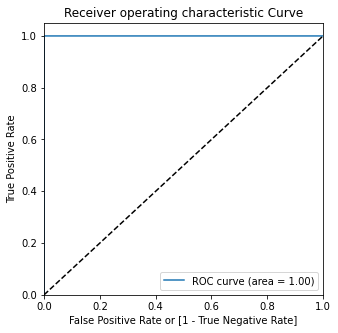

In [115]:
# Plot the ROC curve on train set
draw_roc(y_train_sm, y_train_pred_proba_xgb_smote)

In [116]:
# confusion matrix for test df
print("Accuracy Score for test_df : ",accuracy_score(y_test, y_test_pred_xgb_smote))
confusion_matrix_test_xgb_smote = confusion_matrix(y_test, y_test_pred_xgb_smote)
confusion_matrix_test_xgb_smote

Accuracy Score for test_df :  0.9990871107053826


array([[56833,    33],
       [   19,    77]])

In [117]:
# Metrics - Sensitivity, Specificity on test_df

TP2xgbsm = confusion_matrix_test_xgb_smote[1,1] # true positive 
TN2xgbsm = confusion_matrix_test_xgb_smote[0,0] # true negatives
FP2xgbsm = confusion_matrix_test_xgb_smote[0,1] # false positives
FN2xgbsm = confusion_matrix_test_xgb_smote[1,0] # false negatives

In [118]:
# Sensitivity on test set

sensitivity_test_xgb_sm = TP2xgbsm / float(TP2xgbsm+FN2xgbsm)
print("Sensitivity on test_df : " , sensitivity_test_xgb_sm)

Sensitivity on test_df :  0.8020833333333334


In [119]:
# Specificity on test set

specificity_test_xgb_sm = TN2xgbsm / float(TN2xgbsm+FP2xgbsm)
print("Specificity on test_df : " , specificity_test_xgb_sm)

Specificity on test_df :  0.9994196883902507


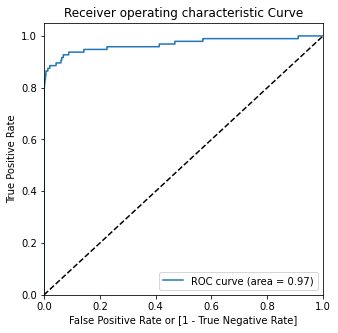

In [120]:
# Plot the ROC curve on test set

draw_roc(y_test, y_test_pred_proba_xgb_smote)

In [121]:
# XGBoost on SMOTE class balanced data

xgb_SMOTE_result = [['Model', 'Sensitivity', 'Specificity', 'Accuracy', 'ROC AUC'], 
                    ['XGBoost(SMOTE)', sensitivity_test_xgb_sm, specificity_test_xgb_sm, accuracy_score(y_test, y_test_pred_xgb_smote), metrics.roc_auc_score(y_true=y_test, y_score=xgb_model_smote_final.predict_proba(X_test)[:, 1])]]

print(tabulate(xgb_SMOTE_result, headers='firstrow', tablefmt='grid'))

+----------------+---------------+---------------+------------+-----------+
| Model          |   Sensitivity |   Specificity |   Accuracy |   ROC AUC |
+================+===============+===============+============+===========+
| XGBoost(SMOTE) |      0.802083 |       0.99942 |   0.999087 |  0.967529 |
+----------------+---------------+---------------+------------+-----------+



### **RANDOM FOREST (SMOTE BALANCED)**

---



---

In [122]:
%%time
# instantiate RandomForest Classifier

rf_smote = RandomForestClassifier(random_state=42)


# Defining parameters for GridSearchCV

parameters_rf_smote = { 'max_depth' : [1, 2, 5, 10, 20],
                             'min_samples_leaf' : [5, 10, 20, 50],
                             'max_features' : [2, 3, 4, 6 ],
                             'n_estimators' : [10, 30, 50, 100, 200],
                             'min_samples_split' : [2, 4, 5, 7, 9, 10],
                             'bootstrap' :  [True]
                           }


# performing GridSearchCV on RF Classifier

rf_model_smote = HalvingGridSearchCV(estimator=rf_smote,
                                     param_grid=parameters_rf_smote,
                                     cv=4, verbose=1,
                                     scoring="accuracy"
                                     )



# Fitting Model

rf_model_smote.fit(X_train_sm, y_train_sm)

n_iterations: 8
n_required_iterations: 8
n_possible_iterations: 8
min_resources_: 181
max_resources_: 398028
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 2400
n_resources: 181
Fitting 4 folds for each of 2400 candidates, totalling 9600 fits
----------
iter: 1
n_candidates: 800
n_resources: 543
Fitting 4 folds for each of 800 candidates, totalling 3200 fits
----------
iter: 2
n_candidates: 267
n_resources: 1629
Fitting 4 folds for each of 267 candidates, totalling 1068 fits
----------
iter: 3
n_candidates: 89
n_resources: 4887
Fitting 4 folds for each of 89 candidates, totalling 356 fits
----------
iter: 4
n_candidates: 30
n_resources: 14661
Fitting 4 folds for each of 30 candidates, totalling 120 fits
----------
iter: 5
n_candidates: 10
n_resources: 43983
Fitting 4 folds for each of 10 candidates, totalling 40 fits
----------
iter: 6
n_candidates: 4
n_resources: 131949
Fitting 4 folds for each of 4 candidates, totalling 16 fits
----------
iter: 7
n_candidate

In [123]:
# cv results
cv_results_rf_model_smote = pd.DataFrame(rf_model_smote.cv_results_)
cv_results_rf_model_smote

,iter,n_resources,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_bootstrap,param_max_depth,param_max_features,param_min_samples_leaf,param_min_samples_split,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,mean_train_score,std_train_score
0,0,181,0.023231,0.001370,0.002207,0.000637,True,1,2,5,2,10,"{'bootstrap': True, 'max_depth': 1, 'max_featu...",0.955556,0.866667,0.911111,0.866667,0.900000,0.036851,3255,0.903704,0.888889,0.948148,0.948148,0.922222,0.026450
1,0,181,0.060326,0.006620,0.002284,0.000424,True,1,2,5,2,30,"{'bootstrap': True, 'max_depth': 1, 'max_featu...",0.955556,0.866667,0.911111,0.844444,0.894444,0.042673,3537,0.896296,0.888889,0.933333,0.933333,0.912963,0.020538
2,0,181,0.075875,0.002212,0.001876,0.000141,True,1,2,5,2,50,"{'bootstrap': True, 'max_depth': 1, 'max_featu...",0.977778,0.866667,0.911111,0.844444,0.900000,0.050918,3255,0.903704,0.888889,0.948148,0.933333,0.918519,0.023424
3,0,181,0.143554,0.000605,0.004431,0.002167,True,1,2,5,2,100,"{'bootstrap': True, 'max_depth': 1, 'max_featu...",0.977778,0.866667,0.911111,0.844444,0.900000,0.050918,3255,0.896296,0.888889,0.948148,0.933333,0.916667,0.024776
4,0,181,0.284122,0.000784,0.003236,0.000840,True,1,2,5,2,200,"{'bootstrap': True, 'max_depth': 1, 'max_featu...",0.977778,0.866667,0.911111,0.844444,0.900000,0.050918,3255,0.896296,0.888889,0.948148,0.933333,0.916667,0.024776
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3597,6,131949,0.241082,0.003906,0.021507,0.008479,True,20,4,5,4,50,"{'bootstrap': True, 'max_depth': 20, 'max_feat...",0.999363,0.999303,0.999242,0.999091,0.999250,0.000101,3,0.999768,0.999798,0.999828,0.999727,0.999780,0.000037
3598,6,131949,0.242336,0.005893,0.015209,0.000159,True,20,4,5,7,50,"{'bootstrap': True, 'max_depth': 20, 'max_feat...",0.999363,0.999303,0.999242,0.999091,0.999250,0.000101,3,0.999768,0.999798,0.999828,0.999727,0.999780,0.000037
3599,6,131949,0.242894,0.002942,0.015319,0.000227,True,20,4,5,5,50,"{'bootstrap': True, 'max_depth': 20, 'max_feat...",0.999363,0.999303,0.999242,0.999091,0.999250,0.000101,3,0.999768,0.999798,0.999828,0.999727,0.999780,0.000037
3600,7,395847,0.672395,0.100479,0.036397,0.002238,True,20,4,5,7,50,"{'bootstrap': True, 'max_depth': 20, 'max_feat...",0.999677,0.999717,0.999788,0.999717,0.999725,0.000040,1,0.999845,0.999835,0.999801,0.999845,0.999832,0.000018


In [124]:
# Checking best parameters, best score and best estimator of above RandomForest model on SMOTE class balanced data

print(rf_model_smote.best_params_)
print(rf_model_smote.best_score_)
print(rf_model_smote.best_estimator_)

{'bootstrap': True, 'max_depth': 20, 'max_features': 4, 'min_samples_leaf': 5, 'min_samples_split': 7, 'n_estimators': 50}
0.9997246389992017
RandomForestClassifier()


In [125]:
## Final Model for Random Forest


rf_model_smote_final = RandomForestClassifier(random_state=42, 
                                                  max_depth=20, 
                                                  max_features= 4, 
                                                  n_estimators=50,
                                                  min_samples_leaf= 5,
                                                  min_samples_split= 7,
                                                  bootstrap= True)


rf_model_smote_final.fit(X_train_sm, y_train_sm)

RandomForestClassifier()

In [127]:
# ROC AUC score on train-test set

print('ROC AUC on train data by Random Forest =', metrics.roc_auc_score(y_true=y_train_sm,
                                                              y_score=rf_model_smote_final.predict_proba(X_train_sm)[:, 1]))

print('ROC AUC on test data by Random Forest =', metrics.roc_auc_score(y_true=y_test,
                                                             y_score=rf_model_smote_final.predict_proba(X_test)[:, 1]))

ROC AUC on train data by Random Forest = 0.9999998762831589
ROC AUC on test data by Random Forest = 0.9515280439981711


In [128]:
# Predicting y_pred for train and test sets

y_train_pred_rf_smote = rf_model_smote_final.predict(X_train_sm)
y_test_pred_rf_smote = rf_model_smote_final.predict(X_test)

In [129]:
# Predicting y_pred_proba for train and test sets
y_train_pred_proba_rf_smote = rf_model_smote_final.predict_proba(X_train_sm)[:,1]
y_test_pred_proba_rf_smote = rf_model_smote_final.predict_proba(X_test)[:,1]

In [130]:
# confusion matrix for train df for RandomForest

print("Accuracy Score for train_df : ", accuracy_score(y_train_sm, y_train_pred_rf_smote))
confusion_matrix_train_rf_smote = confusion_matrix(y_train_sm, y_train_pred_rf_smote)
confusion_matrix_train_rf_smote

Accuracy Score for train_df :  0.9998316701337594


array([[198947,     67],
       [     0, 199014]])

In [131]:
# Metrics - Sensitivity, Specificity

TP1rfsm1 = confusion_matrix_train_rf_smote[1,1] # true positive 
TN1rfsm1 = confusion_matrix_train_rf_smote[0,0] # true negatives
FP1rfsm1 = confusion_matrix_train_rf_smote[0,1] # false positives
FN1rfsm1 = confusion_matrix_train_rf_smote[1,0] # false negatives

In [132]:
# sensitivity on train df for RandomForest

sensitivity_train_rf_smote = TP1rfsm1 / float(TP1rfsm1+FN1rfsm1)
print("Sensitivity on train_df : " , sensitivity_train_rf_smote)

Sensitivity on train_df :  1.0


In [133]:
# specificity on train for RandomForest

specificity_train_rf_smote = TN1rfsm1 / float(TN1rfsm1+FP1rfsm1)
print("Specificity on train_df : " , specificity_train_rf_smote)

Specificity on train_df :  0.9996633402675189


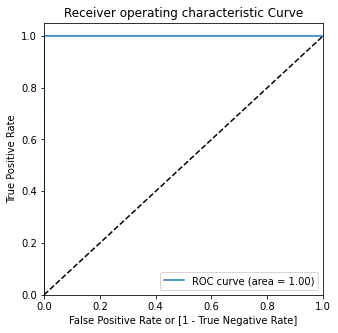

In [134]:
# Plot the ROC curve on train set

draw_roc(y_train_sm, y_train_pred_proba_rf_smote)

In [135]:
# confusion matrix for test df
print("Accuracy Score for test_df : ",accuracy_score(y_test, y_test_pred_rf_smote))
confusion_matrix_test_rf_smote = confusion_matrix(y_test, y_test_pred_rf_smote)
confusion_matrix_test_rf_smote

Accuracy Score for test_df :  0.9988939995084443


array([[56824,    42],
       [   21,    75]])

In [136]:
# Metrics - Sensitivity, Specificity for RandomForest

TP2rfsm2 = confusion_matrix_test_rf_smote[1,1] # true positive 
TN2rfsm2 = confusion_matrix_test_rf_smote[0,0] # true negatives
FP2rfsm2 = confusion_matrix_test_rf_smote[0,1] # false positives
FN2rfsm2 = confusion_matrix_test_rf_smote[1,0] # false negatives

In [137]:
# sensitivity on test for RandomForest

sensitivity_test_rf_smote = TP2rfsm2 / float(TP2rfsm2+FN2rfsm2)
print("Sensitivity on test_df : " , sensitivity_test_rf_smote)

Sensitivity on test_df :  0.78125


In [138]:
# specificity on test for RandomForest

specificity_test_rf_smote = TN2rfsm2 / float(TN2rfsm2+FP2rfsm2)
print("Specificity on test_df : " , specificity_test_rf_smote)

Specificity on test_df :  0.9992614215875919


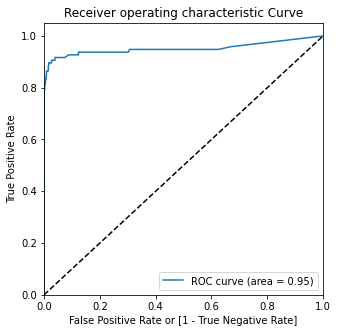

In [139]:
# Plot the ROC curve on test set

draw_roc(y_test, y_test_pred_proba_rf_smote)

In [140]:
# Random Forest model on SMOTE class balanced data

rf_smote_result = [['Model', 'Sensitivity', 'Specificity', 'Accuracy', 'ROC AUC'], 
                   ['Random Forest(SMOTE)', sensitivity_test_rf_smote, specificity_test_rf_smote, accuracy_score(y_test, y_test_pred_rf_smote), metrics.roc_auc_score(y_true=y_test, y_score=rf_model_smote_final.predict_proba(X_test)[:, 1])]]

print(tabulate(rf_smote_result, headers='firstrow', tablefmt='grid'))

+----------------------+---------------+---------------+------------+-----------+
| Model                |   Sensitivity |   Specificity |   Accuracy |   ROC AUC |
+======================+===============+===============+============+===========+
| Random Forest(SMOTE) |       0.78125 |      0.999261 |   0.998894 |  0.951528 |
+----------------------+---------------+---------------+------------+-----------+



### **Logistic Regression (SMOTE Balanced)**

---



---

In [141]:
%%time
# Specify params
params_LR_smote = {"C": [0.01, 0.1, 1, 5, 10, 20, 50, 100]}

LR = LogisticRegression()

# Specifing score as recall as we are more focused on acheiving the higher sensitivity than the accuracy
LR_model_smote = GridSearchCV(estimator = LR,
                              param_grid = params_LR_smote, 
                              scoring= 'roc_auc', 
                              cv = 4, 
                              verbose = 1,
                              return_train_score=True) 

# Fit the model
LR_model_smote.fit(X_train_sm, y_train_sm)

Fitting 4 folds for each of 8 candidates, totalling 32 fits
CPU times: user 2min 3s, sys: 2min 5s, total: 4min 8s
Wall time: 1min 5s


In [142]:
# results of grid search CV
cv_results_LR_model_smote = pd.DataFrame(LR_model_smote.cv_results_)
cv_results_LR_model_smote

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,mean_train_score,std_train_score
0,1.617646,0.020820,0.056338,0.001092,0.01,{'C': 0.01},0.991173,0.991542,0.991448,0.991490,0.991413,0.000143,8,0.991556,0.991437,0.991362,0.991364,0.991430,0.000079
1,1.708332,0.078726,0.055702,0.000500,0.1,{'C': 0.1},0.991230,0.991554,0.991475,0.991520,0.991445,0.000127,7,0.991590,0.991458,0.991397,0.991400,0.991461,0.000078
2,1.756256,0.039263,0.059144,0.003049,1,{'C': 1},0.991234,0.991552,0.991476,0.991521,0.991446,0.000125,6,0.991591,0.991457,0.991399,0.991402,0.991462,0.000078
3,1.740809,0.060346,0.056570,0.001044,5,{'C': 5},0.991235,0.991552,0.991476,0.991521,0.991446,0.000125,5,0.991592,0.991457,0.991399,0.991402,0.991462,0.000078
4,1.877682,0.229273,0.059284,0.003912,10,{'C': 10},0.991235,0.991552,0.991476,0.991521,0.991446,0.000125,2,0.991592,0.991457,0.991399,0.991402,0.991462,0.000078
5,1.737175,0.053422,0.056883,0.001635,20,{'C': 20},0.991235,0.991552,0.991476,0.991521,0.991446,0.000125,1,0.991592,0.991457,0.991399,0.991402,0.991462,0.000078
6,1.737307,0.030123,0.055155,0.000368,50,{'C': 50},0.991235,0.991552,0.991476,0.991521,0.991446,0.000125,4,0.991592,0.991457,0.991399,0.991402,0.991462,0.000078
7,1.744002,0.043856,0.059153,0.006204,100,{'C': 100},0.991235,0.991552,0.991476,0.991521,0.991446,0.000125,3,0.991592,0.991457,0.991399,0.991402,0.991462,0.000078


In [143]:
# Checking best parameters, best score and best estimator of above RandomForest model

print(LR_model_smote.best_params_)
print(LR_model_smote.best_score_)
print(LR_model_smote.best_estimator_)

{'C': 20}
0.9914458444331511
LogisticRegression(C=20)


In [144]:
## Final Model for Logistic Regression


# Instantiate the model with best C
LR_model_smote_fnl = LogisticRegression(C=20)

# Fit the model on the train set
LR_model_smote_final = LR_model_smote_fnl.fit(X_train_sm, y_train_sm)

In [145]:
# ROC AUC score on train-test set

print('ROC AUC on train data by Logistic Regression =', metrics.roc_auc_score(y_true=y_train_sm,
                                                              y_score=LR_model_smote_final.predict_proba(X_train_sm)[:, 1]))

print('ROC AUC on test data by Logistic Regression =', metrics.roc_auc_score(y_true=y_test,
                                                             y_score=LR_model_smote_final.predict_proba(X_test)[:, 1]))

ROC AUC on train data by Logistic Regression = 0.9914568139392237
ROC AUC on test data by Logistic Regression = 0.9697356871123928


In [146]:
# Predicting y_pred for train and test sets

y_train_pred_LR_smote = LR_model_smote_final.predict(X_train_sm)
y_test_pred_LR_smote = LR_model_smote_final.predict(X_test)

In [147]:
# Predicting y_pred_proba for train and test sets
y_train_pred_proba_LR_smote = LR_model_smote_final.predict_proba(X_train_sm)[:,1]
y_test_pred_proba_LR_smote = LR_model_smote_final.predict_proba(X_test)[:,1]

In [148]:
# confusion matrix for train df for Logistic Regression

print("Accuracy Score for train_df : ", accuracy_score(y_train_sm, y_train_pred_LR_smote))
confusion_matrix_train_LR_smote = confusion_matrix(y_train_sm, y_train_pred_LR_smote)
confusion_matrix_train_LR_smote

Accuracy Score for train_df :  0.9519154431346538


array([[194050,   4964],
       [ 14175, 184839]])

In [149]:
# Metrics - Sensitivity, Specificity

TP1LrSm1 = confusion_matrix_train_LR_smote[1,1] # true positive 
TN1LrSm1 = confusion_matrix_train_LR_smote[0,0] # true negatives
FP1LrSm1 = confusion_matrix_train_LR_smote[0,1] # false positives
FN1LrSm1 = confusion_matrix_train_LR_smote[1,0] # false negatives

In [150]:
# sensitivity on train df for Logistic Regression

sensitivity_train_LR_smote = TP1LrSm1 / float(TP1LrSm1+FN1LrSm1)
print("Sensitivity on train_df : " , sensitivity_train_LR_smote)

Sensitivity on train_df :  0.928773855105671


In [151]:
# specificity on train for Logistic Regression

specificity_train_LR_smote = TN1LrSm1 / float(TN1LrSm1+FP1LrSm1)
print("Initial specificity on train_df : " , specificity_train_LR_smote)

Initial specificity on train_df :  0.9750570311636367


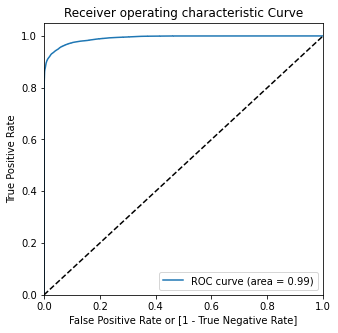

In [152]:
# Plot the ROC curve on train set

draw_roc(y_train_sm, y_train_pred_proba_LR_smote)

In [153]:
# confusion matrix for test df
print("Accuracy Score for test_df : ",accuracy_score(y_test, y_test_pred_LR_smote))
confusion_matrix_test_LR_smote = confusion_matrix(y_test, y_test_pred_LR_smote)
confusion_matrix_test_LR_smote

Accuracy Score for test_df :  0.9738948772866122


array([[55389,  1477],
       [   10,    86]])

In [154]:
# Metrics - Sensitivity, Specificity for Logistic Regression

TP2LrSm2 = confusion_matrix_test_LR_smote[1,1] # true positive 
TN2LrSm2 = confusion_matrix_test_LR_smote[0,0] # true negatives
FP2LrSm2 = confusion_matrix_test_LR_smote[0,1] # false positives
FN2LrSm2 = confusion_matrix_test_LR_smote[1,0] # false negatives

In [155]:
# sensitivity on test for Logistic Regression

sensitivity_test_LR_smote = TP2LrSm2 / float(TP2LrSm2 + FN2LrSm2)
print("Sensitivity on test_df : " , sensitivity_test_LR_smote)

Sensitivity on test_df :  0.8958333333333334


In [156]:
# specificity on test for Logistic Regression

specificity_test_LR_smote = TN2LrSm2 / float(TN2LrSm2 + FP2LrSm2)
print("Specificity on test_df : " , specificity_test_LR_smote)

Specificity on test_df :  0.9740266591636478


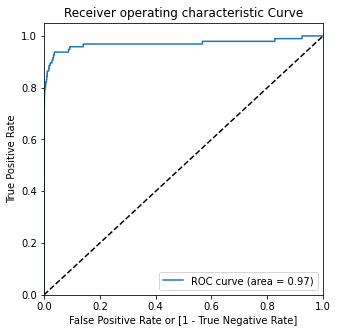

In [157]:
# Plot the ROC curve o test set

draw_roc(y_test, y_test_pred_proba_LR_smote)

In [158]:
# Logistic Regression model on SMOTE class balanced data

LR_smote_result = [['Model', 'Sensitivity', 'Specificity', 'Accuracy', 'ROC AUC'], 
                   ['Logistic Regression(SMOTE)', sensitivity_test_LR_smote, specificity_test_LR_smote, accuracy_score(y_test, y_test_pred_LR_smote), metrics.roc_auc_score(y_true=y_test, y_score=LR_model_smote_final.predict_proba(X_test)[:, 1])]]

print(tabulate(LR_smote_result, headers='firstrow', tablefmt='grid'))

+----------------------------+---------------+---------------+------------+-----------+
| Model                      |   Sensitivity |   Specificity |   Accuracy |   ROC AUC |
+============================+===============+===============+============+===========+
| Logistic Regression(SMOTE) |      0.895833 |      0.974027 |   0.973895 |  0.969736 |
+----------------------------+---------------+---------------+------------+-----------+


#### Metrics for XGBoost, Random Forest and Logistic Regression on SMOTE balanced data

In [159]:
# Metrics for XGBoost, Random Forest and Logistic Regression on SMOTE balanced data

All_model_smote_result = [['Model', 'Sensitivity', 'Specificity', 'Accuracy', 'ROC AUC'], 
                               ['XGBoost(SMOTE)', sensitivity_test_xgb_sm, specificity_test_xgb_sm, accuracy_score(y_test, y_test_pred_xgb_smote), metrics.roc_auc_score(y_true=y_test, y_score=xgb_model_smote_final.predict_proba(X_test)[:, 1])],
                               ['Random Forest(SMOTE)', sensitivity_test_rf_smote, specificity_test_rf_smote, accuracy_score(y_test, y_test_pred_rf_smote), metrics.roc_auc_score(y_true=y_test, y_score=rf_model_smote_final.predict_proba(X_test)[:, 1])],
                               ['Logistic Regression(SMOTE)', sensitivity_test_LR_smote, specificity_test_LR_smote, accuracy_score(y_test, y_test_pred_LR_smote), metrics.roc_auc_score(y_true=y_test, y_score=LR_model_smote_final.predict_proba(X_test)[:, 1])]]

print(tabulate(All_model_smote_result, headers='firstrow', tablefmt='grid'))

+----------------------------+---------------+---------------+------------+-----------+
| Model                      |   Sensitivity |   Specificity |   Accuracy |   ROC AUC |
+============================+===============+===============+============+===========+
| XGBoost(SMOTE)             |      0.802083 |      0.99942  |   0.999087 |  0.967529 |
+----------------------------+---------------+---------------+------------+-----------+
| Random Forest(SMOTE)       |      0.78125  |      0.999261 |   0.998894 |  0.951528 |
+----------------------------+---------------+---------------+------------+-----------+
| Logistic Regression(SMOTE) |      0.895833 |      0.974027 |   0.973895 |  0.969736 |
+----------------------------+---------------+---------------+------------+-----------+


#### Inference:
- We are going to Evaluate Model on `Sensitivity` and `ROC AUC`.
- Sensitivity: The ability of a model to correctly identify transactions as Fraudulent.
- From all the models that we ran on `SMOTE` Class balanced data `Logistic Regression` has highest `Sensitivity:0.895` and `ROC AUC:0.97`.


## **ADASYN: Adaptive Synthetic Sampling**

---



---

In [160]:
# Importing adasyn

from imblearn.over_sampling import ADASYN

In [161]:
# Instantiate adasyn

adasyn = ADASYN(random_state=0)
X_train_adasyn, y_train_adasyn = adasyn.fit_resample(X_train, y_train)

In [162]:
# Before and after shape of training set after doing ADASYN oversampling

print('Before ADASYN oversampling X_train shape=', X_train.shape)
print('After ADASYN oversampling X_train shape=', X_train_adasyn.shape)

Before ADASYN oversampling X_train shape= (199364, 29)
After ADASYN oversampling X_train shape= (398002, 29)


In [163]:
# Befor oversampling class distribution
print('Before ADASYN Over-sampling class distribution:-', collections.Counter(y_train))

# After oversampling class distribution 
print('After ADASYN Over-sampling class distribution:-', collections.Counter(y_train_adasyn))

Before ADASYN Over-sampling class distribution:- Counter({0: 199014, 1: 350})
After ADASYN Over-sampling class distribution:- Counter({0: 199014, 1: 198988})




### **XGBoost (**ADASYN**)**

---



---

In [164]:
%%time
# XGBoost with some of hyperparameter

# Trying for some of hyperparameters
param_grid = {'learning_rate': [0.2, 0.3, 0.5, 0.6], 
             'n_estimators': [50,100,150] }          


# specify model
xgb_model_adasyn = xgboost.XGBClassifier(tree_method='gpu_hist', max_bin=16, predictor='gpu_predictor', gpu_id=0)

scorer = metrics.make_scorer(metrics.roc_auc_score,
                             greater_is_better=True,
                             needs_proba=True,
                             needs_threshold=False)

# set up GridSearchCV()
xgb_model_adasyn_bal = GridSearchCV(estimator = xgb_model_adasyn, 
                                    param_grid = param_grid, 
                                    scoring= scorer, 
                                    cv = 4, 
                                    verbose = 1,
                                    return_train_score=True)      

# fitting the model
xgb_model_adasyn_bal.fit(X_train_adasyn, y_train_adasyn, eval_metric='auc')

Fitting 4 folds for each of 12 candidates, totalling 48 fits
CPU times: user 1min 24s, sys: 2.41 s, total: 1min 26s
Wall time: 46.6 s


In [165]:
# cv results
cv_results_xgb_adasyn = pd.DataFrame(xgb_model_adasyn_bal.cv_results_)
cv_results_xgb_adasyn

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,mean_train_score,std_train_score
0,0.515366,0.064399,0.069075,0.001509,0.2,50,"{'learning_rate': 0.2, 'n_estimators': 50}",0.974993,0.995071,0.999557,0.995490,0.991278,0.009564,12,0.999903,0.999892,0.999908,0.999906,0.999902,6.139904e-06
1,0.702677,0.004768,0.074308,0.007753,0.2,100,"{'learning_rate': 0.2, 'n_estimators': 100}",0.983034,0.998536,0.999862,0.998622,0.995013,0.006936,6,0.999995,0.999995,0.999993,0.999994,0.999994,5.992044e-07
2,0.911507,0.005532,0.071410,0.001604,0.2,150,"{'learning_rate': 0.2, 'n_estimators': 150}",0.985394,0.999352,0.999912,0.999602,0.996065,0.006164,3,0.999999,0.999999,0.999998,0.999999,0.999999,2.538917e-07
3,0.480236,0.003782,0.069367,0.001461,0.3,50,"{'learning_rate': 0.3, 'n_estimators': 50}",0.977836,0.996671,0.999766,0.998724,0.993249,0.008968,10,0.999975,0.999983,0.999974,0.999982,0.999979,4.176054e-06
4,0.703633,0.007537,0.069495,0.000522,0.3,100,"{'learning_rate': 0.3, 'n_estimators': 100}",0.979246,0.999162,0.999897,0.999743,0.994512,0.008818,7,0.999999,0.999999,0.999999,0.999999,0.999999,2.727653e-07
5,0.880415,0.003988,0.073835,0.004980,0.3,150,"{'learning_rate': 0.3, 'n_estimators': 150}",0.981870,0.999471,0.999916,0.999817,0.995268,0.007738,5,1.000000,1.000000,1.000000,1.000000,1.000000,5.167784e-08
6,0.481252,0.003590,0.069572,0.000367,0.5,50,"{'learning_rate': 0.5, 'n_estimators': 50}",0.968964,0.999214,0.999830,0.999303,0.991828,0.013202,11,0.999998,0.999997,0.999998,0.999999,0.999998,7.354203e-07
7,0.668887,0.007323,0.070976,0.002046,0.5,100,"{'learning_rate': 0.5, 'n_estimators': 100}",0.974476,0.999610,0.999898,0.999661,0.993412,0.010933,9,1.000000,1.000000,1.000000,1.000000,1.000000,1.917312e-08
8,0.836469,0.020520,0.070618,0.000866,0.5,150,"{'learning_rate': 0.5, 'n_estimators': 150}",0.975964,0.999673,0.999909,0.999703,0.993812,0.010305,8,1.000000,1.000000,1.000000,1.000000,1.000000,1.087664e-08
9,0.472604,0.005091,0.069605,0.000739,0.6,50,"{'learning_rate': 0.6, 'n_estimators': 50}",0.984331,0.999021,0.999892,0.999569,0.995703,0.006573,4,0.999999,0.999999,0.999999,0.999998,0.999999,4.032331e-07


In [166]:
# Checking best parameters, best score and best estimator of above XGBoost model on ADASYN class balanced data

print(xgb_model_adasyn_bal.best_params_)
print(xgb_model_adasyn_bal.best_score_)
print(xgb_model_adasyn_bal.best_estimator_)

{'learning_rate': 0.6, 'n_estimators': 100}
0.996995963781586
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=0, importance_type=None,
              interaction_constraints='', learning_rate=0.6, max_bin=16,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=4,
              num_parallel_tree=1, predictor='gpu_predictor', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='gpu_hist', validate_parameters=1, verbosity=None)


In [167]:
%%time

# Run for best hyperparameters

param_grid = {"learning_rate": [ 0.01, 0.1, 0.2, 0.3],
               "max_depth": [4, 5, 7, 9 ,10],
               "subsample": [0.2, 0.4, 0.5, 0.6, 0.9],
               "min_child_weight": [1, 3, 5, 7, 10],
               "n_estimators": [25, 50, 100]
              }

scorer = metrics.make_scorer(metrics.roc_auc_score,
                             greater_is_better=True,
                             needs_proba=True,
                             needs_threshold=False)

xgb_model_adasyn_bal_fnl = GridSearchCV(estimator = xgb_model_adasyn, 
                                       param_grid = param_grid, 
                                       scoring= scorer, 
                                       cv = 4, 
                                       verbose = 1,
                                       return_train_score=True)
                    
# fitting the model                    
xgb_model_adasyn_bal_fnl.fit(X_train_adasyn, y_train_adasyn, eval_metric='auc')

Fitting 4 folds for each of 1500 candidates, totalling 6000 fits
CPU times: user 2h 41min 13s, sys: 4min 59s, total: 2h 46min 12s
Wall time: 1h 25min 39s


In [168]:
# cv results
cv_results_xgb_adasyn_fnl = pd.DataFrame(xgb_model_adasyn_bal_fnl.cv_results_)
cv_results_xgb_adasyn_fnl

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_max_depth,param_min_child_weight,param_n_estimators,param_subsample,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,mean_train_score,std_train_score
0,0.346326,0.025825,0.064212,0.000448,0.01,4,1,25,0.2,"{'learning_rate': 0.01, 'max_depth': 4, 'min_c...",0.916621,0.952346,0.950962,0.963415,0.945836,0.017544,1476,0.973604,0.972492,0.965680,0.961432,0.968302,4.993489e-03
1,0.308729,0.002143,0.065663,0.001227,0.01,4,1,25,0.4,"{'learning_rate': 0.01, 'max_depth': 4, 'min_c...",0.916226,0.950975,0.950831,0.962645,0.945169,0.017384,1486,0.974013,0.971620,0.965600,0.961104,0.968085,5.063356e-03
2,0.311499,0.003759,0.063528,0.001078,0.01,4,1,25,0.5,"{'learning_rate': 0.01, 'max_depth': 4, 'min_c...",0.917190,0.950729,0.950957,0.963312,0.945547,0.017145,1481,0.974193,0.971455,0.965140,0.960752,0.967885,5.266600e-03
3,0.307113,0.002045,0.062469,0.000462,0.01,4,1,25,0.6,"{'learning_rate': 0.01, 'max_depth': 4, 'min_c...",0.913474,0.950661,0.951118,0.962741,0.944498,0.018555,1499,0.973716,0.970804,0.965156,0.960209,0.967471,5.201080e-03
4,0.312336,0.006562,0.063007,0.000886,0.01,4,1,25,0.9,"{'learning_rate': 0.01, 'max_depth': 4, 'min_c...",0.910360,0.953116,0.952581,0.962363,0.944605,0.020150,1493,0.973353,0.973760,0.965626,0.958951,0.967922,6.110007e-03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1495,0.670342,0.008364,0.068756,0.000483,0.3,10,10,100,0.2,"{'learning_rate': 0.3, 'max_depth': 10, 'min_c...",0.976735,0.999019,0.999719,0.998470,0.993486,0.009681,199,0.999942,0.999947,0.999947,0.999954,0.999948,4.245275e-06
1496,0.737124,0.010781,0.069580,0.001020,0.3,10,10,100,0.4,"{'learning_rate': 0.3, 'max_depth': 10, 'min_c...",0.977022,0.998510,0.999783,0.999297,0.993653,0.009613,171,0.999981,0.999983,0.999986,0.999994,0.999986,4.905165e-06
1497,0.746871,0.019986,0.073377,0.008897,0.3,10,10,100,0.5,"{'learning_rate': 0.3, 'max_depth': 10, 'min_c...",0.974637,0.998770,0.999852,0.999189,0.993112,0.010673,249,0.999989,0.999993,0.999994,0.999993,0.999993,1.972794e-06
1498,0.764198,0.016788,0.071226,0.005193,0.3,10,10,100,0.6,"{'learning_rate': 0.3, 'max_depth': 10, 'min_c...",0.983229,0.999041,0.999865,0.999271,0.995351,0.007006,28,0.999987,0.999996,0.999995,0.999995,0.999993,3.719221e-06


In [169]:
# Checking best parameters, best score and best estimator of above XGBoost model on ADASYN class balanced data

print(xgb_model_adasyn_bal_fnl.best_params_)
print(xgb_model_adasyn_bal_fnl.best_score_)
print(xgb_model_adasyn_bal_fnl.best_estimator_)

{'learning_rate': 0.3, 'max_depth': 10, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.5}
0.996847913801636
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=0, importance_type=None,
              interaction_constraints='', learning_rate=0.3, max_bin=16,
              max_delta_step=0, max_depth=10, min_child_weight=3, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=4,
              num_parallel_tree=1, predictor='gpu_predictor', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.5,
              tree_method='gpu_hist', validate_parameters=1, verbosity=None)


In [170]:
# Final XGBoost Model for best hyperparameters

xgb_model_adasyn_final = xgboost.XGBClassifier(tree_method='gpu_hist', max_bin=16, predictor='gpu_predictor', gpu_id=0,
                                               subsample= 0.5,
                                               learning_rate=0.3,
                                               max_depth=10,
                                               min_child_weight=3,
                                               n_estimators=100)

xgb_model_adasyn_final.fit(X_train_adasyn, y_train_adasyn, eval_metric='auc')

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=0, importance_type=None,
              interaction_constraints='', learning_rate=0.3, max_bin=16,
              max_delta_step=0, max_depth=10, min_child_weight=3, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=4,
              num_parallel_tree=1, predictor='gpu_predictor', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.5,
              tree_method='gpu_hist', validate_parameters=1, verbosity=None)

In [171]:
# ROC AUC score on train-test set

print('ROC AUC on train data by XGBoost =', metrics.roc_auc_score(y_true=y_train_adasyn,
                                                              y_score=xgb_model_adasyn_final.predict_proba(X_train_adasyn)[:, 1]))

print('ROC AUC on test data by XGBoost =', metrics.roc_auc_score(y_true=y_test,
                                                             y_score=xgb_model_adasyn_final.predict_proba(X_test)[:, 1]))

ROC AUC on train data by XGBoost = 0.9999967569579098
ROC AUC on test data by XGBoost = 0.9608082670957456


In [172]:
# Predicting y_pred for train and test sets

y_train_pred_xgb_adasyn = xgb_model_adasyn_final.predict(X_train_adasyn)
y_test_pred_xgb_adasyn = xgb_model_adasyn_final.predict(X_test)

In [173]:
# Predicting y_pred_proba for train and test sets

y_train_pred_proba_xgb_adasyn = xgb_model_adasyn_final.predict_proba(X_train_adasyn)[:,1]
y_test_pred_proba_xgb_adasyn = xgb_model_adasyn_final.predict_proba(X_test)[:,1]

In [174]:
# confusion matrix for train df 
print("Accuracy Score for train_df : ", accuracy_score(y_train_adasyn, y_train_pred_xgb_adasyn))
confusion_matrix_train_xgb_adasyn = confusion_matrix(y_train_adasyn, y_train_pred_xgb_adasyn)
confusion_matrix_train_xgb_adasyn

Accuracy Score for train_df :  0.9999572866468007


array([[198997,     17],
       [     0, 198988]])

In [175]:
# Metrics - Sensitivity, Specificity on train_df

TP1xgbadsn = confusion_matrix_train_xgb_adasyn[1,1] # true positive 
TN1xgbadsn = confusion_matrix_train_xgb_adasyn[0,0] # true negatives
FP1xgbadsn = confusion_matrix_train_xgb_adasyn[0,1] # false positives
FN1xgbadsn = confusion_matrix_train_xgb_adasyn[1,0] # false negatives

In [176]:
# Sensitivity on train set

sensitivity_train_xgb_adasyn = TP1xgbadsn / float(TP1xgbadsn + FN1xgbadsn)
print("Sensitivity on train_df : " , sensitivity_train_xgb_adasyn)

Sensitivity on train_df :  1.0


In [177]:
# Specificity on test set

specificity_train_xgb_adasyn = TN1xgbadsn / float(TN1xgbadsn + FP1xgbadsn)
print("Specificity on train_df : " , specificity_train_xgb_adasyn)

Specificity on train_df :  0.999914578873848


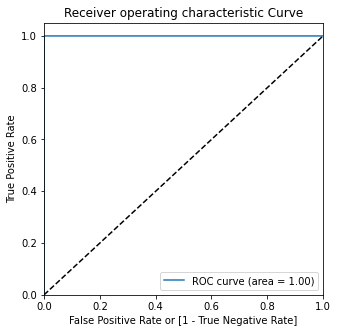

In [178]:
# Plot the ROC curve on train set

draw_roc(y_train_adasyn, y_train_pred_proba_xgb_adasyn)

In [179]:
# confusion matrix for test df
print("Accuracy Score for test_df : ",accuracy_score(y_test, y_test_pred_xgb_adasyn))
confusion_matrix_test_xgb_adasyn = confusion_matrix(y_test, y_test_pred_xgb_adasyn)
confusion_matrix_test_xgb_adasyn

Accuracy Score for test_df :  0.9989466661985184


array([[56827,    39],
       [   21,    75]])

In [180]:
# Metrics - Sensitivity, Specificity on test_df

TP2xgbadsn = confusion_matrix_test_xgb_adasyn[1,1] # true positive 
TN2xgbadsn = confusion_matrix_test_xgb_adasyn[0,0] # true negatives
FP2xgbadsn = confusion_matrix_test_xgb_adasyn[0,1] # false positives
FN2xgbadsn = confusion_matrix_test_xgb_adasyn[1,0] # false negatives

In [181]:
# Sensitivity on test set

sensitivity_test_xgb_adasyn = TP2xgbadsn / float(TP2xgbadsn + FN2xgbadsn)
print("Sensitivity on test_df : " , sensitivity_test_xgb_adasyn)

Sensitivity on test_df :  0.78125


In [182]:
# Specificity on test set

specificity_test_xgb_adasyn = TN2xgbadsn / float(TN2xgbadsn + FP2xgbadsn)
print("Specificity on test_df : " , specificity_test_xgb_adasyn)

Specificity on test_df :  0.9993141771884781


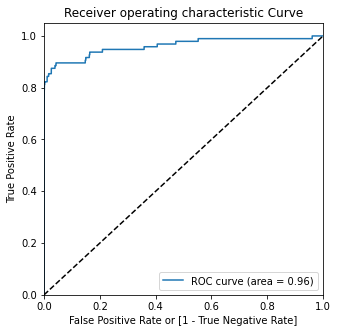

In [183]:
# Plot the ROC curve on test set

draw_roc(y_test, y_test_pred_proba_xgb_adasyn)

In [184]:
# XGBoost model on ADASYN class balanced data

xgb_adasyn_result = [['Model', 'Sensitivity', 'Specificity', 'Accuracy', 'ROC AUC'], 
                    ['XGBoost (ADASYN)', sensitivity_test_xgb_adasyn, specificity_test_xgb_adasyn, accuracy_score(y_test, y_test_pred_xgb_adasyn), metrics.roc_auc_score(y_true=y_test, y_score=xgb_model_adasyn_final.predict_proba(X_test)[:, 1])]]

print(tabulate(xgb_adasyn_result , headers='firstrow', tablefmt='grid'))

+------------------+---------------+---------------+------------+-----------+
| Model            |   Sensitivity |   Specificity |   Accuracy |   ROC AUC |
+==================+===============+===============+============+===========+
| XGBoost (ADASYN) |       0.78125 |      0.999314 |   0.998947 |  0.960808 |
+------------------+---------------+---------------+------------+-----------+



### **RANDOM FOREST (ADASYN)**

---



---



In [185]:
%%time
# instantiate RandomForest Classifier

rf_adasyn = RandomForestClassifier(random_state=42)
 

# Defining parameters for GridSearchCV

parameters_rf_adasyn = { 'max_depth' : [1, 2, 5, 10, 20],
                             'min_samples_leaf' : [5, 10, 20, 50],
                             'max_features' : [2, 3, 4, 6 ],
                             'n_estimators' : [10, 30, 50, 100, 200],
                             'min_samples_split' : [2, 4, 5, 7, 9, 10],
                             'bootstrap' :  [True]
                           }


# performing GridSearchCV on RF Classifier

rf_model_adasyn = HalvingGridSearchCV(estimator=rf_adasyn,
                                     param_grid=parameters_rf_adasyn,
                                     cv=4, verbose=1,
                                     scoring="accuracy"
                                     )



# Fitting Model

rf_model_adasyn.fit(X_train_adasyn, y_train_adasyn)

n_iterations: 8
n_required_iterations: 8
n_possible_iterations: 8
min_resources_: 181
max_resources_: 398002
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 2400
n_resources: 181
Fitting 4 folds for each of 2400 candidates, totalling 9600 fits
----------
iter: 1
n_candidates: 800
n_resources: 543
Fitting 4 folds for each of 800 candidates, totalling 3200 fits
----------
iter: 2
n_candidates: 267
n_resources: 1629
Fitting 4 folds for each of 267 candidates, totalling 1068 fits
----------
iter: 3
n_candidates: 89
n_resources: 4887
Fitting 4 folds for each of 89 candidates, totalling 356 fits
----------
iter: 4
n_candidates: 30
n_resources: 14661
Fitting 4 folds for each of 30 candidates, totalling 120 fits
----------
iter: 5
n_candidates: 10
n_resources: 43983
Fitting 4 folds for each of 10 candidates, totalling 40 fits
----------
iter: 6
n_candidates: 4
n_resources: 131949
Fitting 4 folds for each of 4 candidates, totalling 16 fits
----------
iter: 7
n_candidate

In [186]:
# cv results
cv_results_rf_model_adasyn = pd.DataFrame(rf_model_adasyn.cv_results_)
cv_results_rf_model_adasyn

,iter,n_resources,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_bootstrap,param_max_depth,param_max_features,param_min_samples_leaf,param_min_samples_split,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,mean_train_score,std_train_score
0,0,181,0.025649,0.001658,0.002114,0.000294,True,1,2,5,2,10,"{'bootstrap': True, 'max_depth': 1, 'max_featu...",0.777778,0.755556,0.822222,0.755556,0.777778,0.027217,3339,0.851852,0.874074,0.755556,0.785185,0.816667,0.048113
1,0,181,0.058643,0.005109,0.002592,0.001125,True,1,2,5,2,30,"{'bootstrap': True, 'max_depth': 1, 'max_featu...",0.688889,0.755556,0.755556,0.733333,0.733333,0.027217,3591,0.748148,0.859259,0.770370,0.770370,0.787037,0.042673
2,0,181,0.077477,0.002262,0.003124,0.001475,True,1,2,5,2,50,"{'bootstrap': True, 'max_depth': 1, 'max_featu...",0.733333,0.755556,0.822222,0.733333,0.761111,0.036430,3483,0.777778,0.896296,0.785185,0.762963,0.805556,0.052997
3,0,181,0.147427,0.001157,0.002438,0.000247,True,1,2,5,2,100,"{'bootstrap': True, 'max_depth': 1, 'max_featu...",0.711111,0.755556,0.844444,0.733333,0.761111,0.050614,3453,0.777778,0.896296,0.800000,0.748148,0.805556,0.055525
4,0,181,0.293407,0.002325,0.005491,0.003598,True,1,2,5,2,200,"{'bootstrap': True, 'max_depth': 1, 'max_featu...",0.711111,0.755556,0.844444,0.733333,0.761111,0.050614,3453,0.777778,0.903704,0.807407,0.748148,0.809259,0.058414
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3597,6,131949,0.083874,0.014094,0.011165,0.000275,True,10,6,5,5,10,"{'bootstrap': True, 'max_depth': 10, 'max_feat...",0.907903,0.880104,0.954224,0.958499,0.925183,0.032726,13,0.994624,0.994988,0.993442,0.994180,0.994308,0.000576
3598,6,131949,0.076637,0.001316,0.011997,0.000885,True,10,6,5,4,10,"{'bootstrap': True, 'max_depth': 10, 'max_feat...",0.907903,0.880104,0.954224,0.958499,0.925183,0.032726,13,0.994624,0.994988,0.993442,0.994180,0.994308,0.000576
3599,6,131949,0.074610,0.001019,0.012169,0.000829,True,10,6,5,10,10,"{'bootstrap': True, 'max_depth': 10, 'max_feat...",0.907903,0.880104,0.954224,0.958499,0.925183,0.032726,13,0.994624,0.994988,0.993442,0.994180,0.994308,0.000576
3600,7,395847,0.164259,0.004972,0.030980,0.002870,True,10,6,5,4,10,"{'bootstrap': True, 'max_depth': 10, 'max_feat...",0.893383,0.900315,0.957054,0.954750,0.926376,0.029639,5,0.993843,0.993290,0.992081,0.994533,0.993437,0.000898


In [187]:
# Checking best parameters, best score and best estimator of above RandomForest model on ADASYN class balanced data

print(rf_model_adasyn.best_params_)
print(rf_model_adasyn.best_score_)
print(rf_model_adasyn.best_estimator_)

{'bootstrap': True, 'max_depth': 10, 'max_features': 6, 'min_samples_leaf': 5, 'min_samples_split': 4, 'n_estimators': 10}
0.9263755577990537
RandomForestClassifier()


In [188]:
## Final Model for Random Forest


rf_model_adasyn_final = RandomForestClassifier(random_state=42, 
                                  max_depth=10, 
                                  max_features= 6, 
                                  n_estimators=10,
                                  min_samples_leaf= 5,
                                  min_samples_split= 4,
                                  bootstrap= True,
                                  )

# fitting model
rf_model_adasyn_final.fit(X_train_adasyn, y_train_adasyn)

RandomForestClassifier()

In [190]:
# ROC AUC Score on train-test set

print('ROC AUC on train data by Random Forest =', metrics.roc_auc_score(y_true=y_train_adasyn,
                                                              y_score=rf_model_adasyn_final.predict_proba(X_train_adasyn)[:, 1]))

print('ROC AUC on test data by Random Forest =', metrics.roc_auc_score(y_true=y_test,
                                                             y_score=rf_model_adasyn_final.predict_proba(X_test)[:, 1]))

ROC AUC on train data by Random Forest = 0.9994799029168775
ROC AUC on test data by Random Forest = 0.9599122461869425


In [191]:
# Predicting y_pred for train and test sets

y_train_pred_rf_adasyn = rf_model_adasyn_final.predict(X_train_adasyn)
y_test_pred_rf_adasyn = rf_model_adasyn_final.predict(X_test)

In [192]:
# Predicting y_pred_proba for train and test sets

y_train_pred_proba_rf_adasyn = rf_model_adasyn_final.predict_proba(X_train_adasyn)[:,1]
y_test_pred_proba_rf_adasyn = rf_model_adasyn_final.predict_proba(X_test)[:,1]

In [193]:
# confusion matrix for train df for RandomForest

print("Accuracy Score for train_df : ", accuracy_score(y_train_adasyn, y_train_pred_rf_adasyn))
confusion_matrix_train_rf_adasyn = confusion_matrix(y_train_adasyn, y_train_pred_rf_adasyn)
confusion_matrix_train_rf_adasyn

Accuracy Score for train_df :  0.9928894829674223


array([[196507,   2507],
       [   323, 198665]])

In [194]:
# Metrics - Sensitivity, Specificity

TP1rfadsn1 = confusion_matrix_train_rf_adasyn[1,1] # true positive 
TN1rfadsn1 = confusion_matrix_train_rf_adasyn[0,0] # true negatives
FP1rfadsn1 = confusion_matrix_train_rf_adasyn[0,1] # false positives
FN1rfadsn1 = confusion_matrix_train_rf_adasyn[1,0] # false negatives

In [195]:
# sensitivity on train df for RandomForest

sensitivity_train_rf_adasyn = TP1rfadsn1 / float(TP1rfadsn1 + FN1rfadsn1)
print("Sensitivity on train_df : " , sensitivity_train_rf_adasyn)

Sensitivity on train_df :  0.9983767865398918


In [196]:
# specificity on train for RandomForest

specificity_train_rf_adasyn = TN1rfadsn1 / float(TN1rfadsn1 + FP1rfadsn1)
print("Specificity on train_df : " , specificity_train_rf_adasyn)

Specificity on train_df :  0.9874028962786537


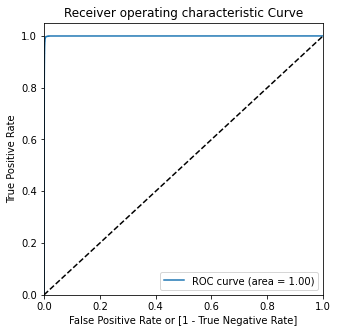

In [197]:
# Plot the ROC curve on train set

draw_roc(y_train_adasyn, y_train_pred_proba_rf_adasyn)

In [198]:
# confusion matrix for test df
print("Accuracy Score for test_df : ", accuracy_score(y_test, y_test_pred_rf_adasyn))
confusion_matrix_test_rf_adasyn = confusion_matrix(y_test, y_test_pred_rf_adasyn)
confusion_matrix_test_rf_adasyn

Accuracy Score for test_df :  0.9864295495242442


array([[56111,   755],
       [   18,    78]])

In [199]:
# Metrics - Sensitivity, Specificity for RandomForest

TP2rfadsn2 = confusion_matrix_test_rf_adasyn[1,1] # true positive 
TN2rfadsn2 = confusion_matrix_test_rf_adasyn[0,0] # true negatives
FP2rfadsn2 = confusion_matrix_test_rf_adasyn[0,1] # false positives
FN2rfadsn2 = confusion_matrix_test_rf_adasyn[1,0] # false negatives

In [200]:
# sensitivity on test for RandomForest

sensitivity_test_rf_adasyn = TP2rfadsn2 / float(TP2rfadsn2+FN2rfadsn2)
print("Sensitivity on test_df : " , sensitivity_test_rf_adasyn)

Sensitivity on test_df :  0.8125


In [201]:
# specificity on test for RandomForest

specificity_test_rf_adasyn = TN2rfadsn2 / float(TN2rfadsn2+FP2rfadsn2)
print("Specificity on test_df : " , specificity_test_rf_adasyn)

Specificity on test_df :  0.9867231737769493


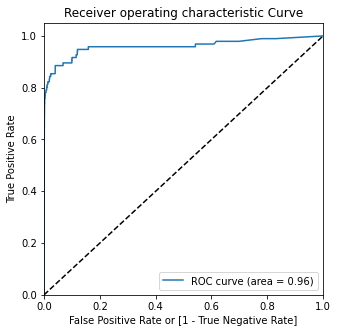

In [202]:
# Plot the ROC curve on test set

draw_roc(y_test, y_test_pred_proba_rf_adasyn)

In [203]:
# Random Forest Model on ADASYN class balanced data

rf_adasyn_result = [['Model', 'Sensitivity', 'Specificity', 'Accuracy', 'ROC AUC'], 
                   ['Random Forest(ADASYN)', sensitivity_test_rf_adasyn, specificity_test_rf_adasyn, accuracy_score(y_test, y_test_pred_rf_adasyn), metrics.roc_auc_score(y_true=y_test, y_score=rf_model_adasyn_final.predict_proba(X_test)[:, 1])]]

print(tabulate(rf_adasyn_result, headers='firstrow', tablefmt='grid'))

+-----------------------+---------------+---------------+------------+-----------+
| Model                 |   Sensitivity |   Specificity |   Accuracy |   ROC AUC |
+=======================+===============+===============+============+===========+
| Random Forest(ADASYN) |        0.8125 |      0.986723 |    0.98643 |  0.959912 |
+-----------------------+---------------+---------------+------------+-----------+



### **Logistic Regression (ADASYN)**

---



---



In [204]:
%%time
# Specify params
params_LR_adasyn = {"C": [0.01, 0.1, 1, 2, 5, 10, 15, 25, 50, 100]}

LR = LogisticRegression()

# Specifing score as recall as we are more focused on acheiving the higher sensitivity than the accuracy
LR_model_adasyn = GridSearchCV(estimator = LR,
                               param_grid = params_LR_adasyn, 
                               scoring= 'roc_auc', 
                               cv = 4, 
                               verbose = 1,
                               return_train_score=True) 

# Fitting the model
LR_model_adasyn.fit(X_train_adasyn, y_train_adasyn)

Fitting 4 folds for each of 10 candidates, totalling 40 fits
CPU times: user 2min 35s, sys: 2min 39s, total: 5min 15s
Wall time: 1min 23s


In [205]:
# results of grid search CV
cv_results_LR_model_adasyn = pd.DataFrame(LR_model_adasyn.cv_results_)
cv_results_LR_model_adasyn

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,mean_train_score,std_train_score
0,1.596401,0.123744,0.053886,0.000686,0.01,{'C': 0.01},0.946975,0.952149,0.950187,0.978030,0.956835,0.012376,1,0.974208,0.971723,0.972523,0.968473,0.971732,0.002084
1,1.634127,0.212903,0.053680,0.000484,0.1,{'C': 0.1},0.945119,0.953328,0.947376,0.978097,0.955980,0.013116,2,0.974359,0.971831,0.972743,0.968638,0.971893,0.002086
2,1.837001,0.229746,0.054218,0.000517,1,{'C': 1},0.944813,0.953472,0.947010,0.978100,0.955849,0.013235,3,0.974371,0.971846,0.972760,0.968653,0.971908,0.002085
3,1.816149,0.223318,0.054377,0.000474,2,{'C': 2},0.944797,0.953480,0.946988,0.978100,0.955841,0.013242,4,0.974372,0.971847,0.972761,0.968654,0.971908,0.002085
4,1.819221,0.214111,0.053728,0.000349,5,{'C': 5},0.944786,0.953483,0.946976,0.978100,0.955836,0.013246,5,0.974372,0.971848,0.972761,0.968654,0.971909,0.002085
5,2.010695,0.457219,0.054912,0.001567,10,{'C': 10},0.944782,0.953487,0.946971,0.978100,0.955835,0.013247,6,0.974372,0.971848,0.972761,0.968654,0.971909,0.002085
6,1.819599,0.238514,0.054674,0.000898,15,{'C': 15},0.944781,0.953487,0.946970,0.978100,0.955834,0.013248,7,0.974372,0.971848,0.972762,0.968654,0.971909,0.002085
7,1.820279,0.246562,0.053931,0.000799,25,{'C': 25},0.944780,0.953488,0.946969,0.978100,0.955834,0.013248,8,0.974372,0.971848,0.972762,0.968654,0.971909,0.002085
8,1.792600,0.241015,0.054032,0.000438,50,{'C': 50},0.944779,0.953488,0.946968,0.978100,0.955834,0.013248,9,0.974372,0.971848,0.972762,0.968654,0.971909,0.002085
9,1.889953,0.155780,0.058641,0.004314,100,{'C': 100},0.944779,0.953488,0.946967,0.978100,0.955833,0.013249,10,0.974373,0.971848,0.972762,0.968654,0.971909,0.002085


In [206]:
# Checking best parameters, best score and best estimator of above Logistic Regression model on ADASYN class balanced data

print(LR_model_adasyn.best_params_)
print(LR_model_adasyn.best_score_)
print(LR_model_adasyn.best_estimator_)

{'C': 0.01}
0.9568349811126573
LogisticRegression(C=0.01)


In [207]:
## Final Model for Logistic Regression


# Instantiate the model with best C
LR_model_adasyn_fnl = LogisticRegression(C=0.01)

# Fit the model on the train set
LR_model_adasyn_final = LR_model_adasyn_fnl.fit(X_train_adasyn, y_train_adasyn)

In [208]:
# ROC AUC score on train-test set

print('ROC AUC on train data by Logistic Regression =', metrics.roc_auc_score(y_true=y_train_adasyn,
                                                              y_score=LR_model_adasyn_final.predict_proba(X_train_adasyn)[:, 1]))

print('ROC AUC on test data by Logistic Regression =', metrics.roc_auc_score(y_true=y_test,
                                                             y_score=LR_model_adasyn_final.predict_proba(X_test)[:, 1]))

ROC AUC on train data by Logistic Regression = 0.9704544719869828
ROC AUC on test data by Logistic Regression = 0.9692334098289546


In [209]:
# Predicting y_pred for train and test sets

y_train_pred_LR_adasyn = LR_model_adasyn_final.predict(X_train_adasyn)
y_test_pred_LR_adasyn = LR_model_adasyn_final.predict(X_test)

In [210]:
# Predicting y_pred_proba for train and test sets

y_train_pred_proba_LR_adasyn = LR_model_adasyn_final.predict_proba(X_train_adasyn)[:,1]
y_test_pred_proba_LR_adasyn = LR_model_adasyn_final.predict_proba(X_test)[:,1]

In [211]:
# confusion matrix for train df for Logistic Regression

print("Accuracy Score for train_df : ", accuracy_score(y_train_adasyn, y_train_pred_LR_adasyn))
confusion_matrix_train_LR_adasyn = confusion_matrix(y_train_adasyn, y_train_pred_LR_adasyn)
confusion_matrix_train_LR_adasyn

Accuracy Score for train_df :  0.9017467248908297


array([[182760,  16254],
       [ 22851, 176137]])

In [212]:
# Metrics - Sensitivity, Specificity

TP1Lradsn1 = confusion_matrix_train_LR_adasyn[1,1] # true positive 
TN1Lradsn1 = confusion_matrix_train_LR_adasyn[0,0] # true negatives
FP1Lradsn1 = confusion_matrix_train_LR_adasyn[0,1] # false positives
FN1Lradsn1 = confusion_matrix_train_LR_adasyn[1,0] # false negatives

In [213]:
# sensitivity on train df for Logistic Regression

sensitivity_train_LR_adasyn = TP1Lradsn1 / float(TP1Lradsn1 + FN1Lradsn1)
print("Sensitivity on train_df : " , sensitivity_train_LR_adasyn)

Sensitivity on train_df :  0.8851639294831849


In [214]:
# specificity on train for Logistic Regression

specificity_train_LR_adasyn = TN1Lradsn1 / float(TN1Lradsn1 + FP1Lradsn1)
print("Specificity on train_df : " , specificity_train_LR_adasyn)

Specificity on train_df :  0.9183273538545027


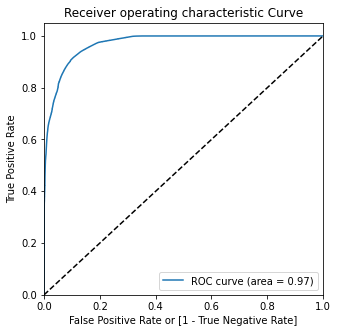

In [215]:
# Plot the ROC curve on train set

draw_roc(y_train_adasyn, y_train_pred_proba_LR_adasyn)

In [216]:
# confusion matrix for test df
print("Accuracy Score for test_df : ", accuracy_score(y_test, y_test_pred_LR_adasyn))
confusion_matrix_test_LR_adasyn = confusion_matrix(y_test, y_test_pred_LR_adasyn)
confusion_matrix_test_LR_adasyn

Accuracy Score for test_df :  0.9162072960921316


array([[52098,  4768],
       [    5,    91]])

In [217]:
# Metrics - Sensitivity, Specificity for Logistic Regression

TP2Lradsn2 = confusion_matrix_test_LR_adasyn[1,1] # true positive 
TN2Lradsn2 = confusion_matrix_test_LR_adasyn[0,0] # true negatives
FP2Lradsn2 = confusion_matrix_test_LR_adasyn[0,1] # false positives
FN2Lradsn2 = confusion_matrix_test_LR_adasyn[1,0] # false negatives

In [218]:
# sensitivity on test for Logistic Regression

sensitivity_test_LR_adasyn = TP2Lradsn2 / float(TP2Lradsn2 + FN2Lradsn2)
print("Sensitivity on test_df : " , sensitivity_test_LR_adasyn)

Sensitivity on test_df :  0.9479166666666666


In [219]:
# specificity on test for Logistic Regression

specificity_test_LR_adasyn = TN2Lradsn2 / float(TN2Lradsn2 + FP2Lradsn2)
print("Specificity on test_df : " , specificity_test_LR_adasyn)

Specificity on test_df :  0.9161537649913832


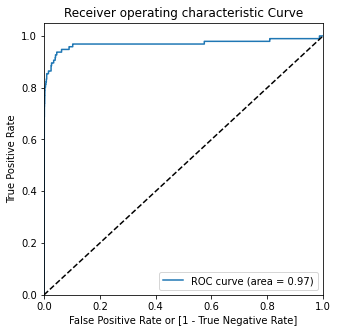

In [220]:
# Plot the ROC curve on test set

draw_roc(y_test, y_test_pred_proba_LR_adasyn)

In [221]:
# Logistic Regression on ADASYN class balanced data

LR_adasyn_result = [['Model', 'Sensitivity', 'Specificity', 'Accuracy', 'ROC AUC'], 
                    ['Logistic Regression(ADASYN)', sensitivity_test_LR_adasyn, specificity_test_LR_adasyn, accuracy_score(y_test, y_test_pred_LR_adasyn) , metrics.roc_auc_score(y_true=y_test, y_score=LR_model_adasyn_final.predict_proba(X_test)[:, 1])]]

print(tabulate(LR_adasyn_result, headers='firstrow', tablefmt='grid'))

+-----------------------------+---------------+---------------+------------+-----------+
| Model                       |   Sensitivity |   Specificity |   Accuracy |   ROC AUC |
+=============================+===============+===============+============+===========+
| Logistic Regression(ADASYN) |      0.947917 |      0.916154 |   0.916207 |  0.969233 |
+-----------------------------+---------------+---------------+------------+-----------+


#### Metrics for XGBoost, Random Forest and Logistic Regression on ADASYN balanced data

In [222]:
# Metrics on XGBoost, Random Forest and Logistic Regression on ADASYN balanced data

All_model_ADASYN_result = [['Model', 'Sensitivity', 'Specificity', 'Accuracy', 'ROC AUC'], 
                           ['XGBoost (ADASYN)', sensitivity_test_xgb_adasyn, specificity_test_xgb_adasyn, accuracy_score(y_test, y_test_pred_xgb_adasyn), metrics.roc_auc_score(y_true=y_test, y_score=xgb_model_adasyn_final.predict_proba(X_test)[:, 1])],
                           ['Random Forest (ADASYN)', sensitivity_test_rf_adasyn, specificity_test_rf_adasyn, accuracy_score(y_test, y_test_pred_rf_adasyn), metrics.roc_auc_score(y_true=y_test, y_score=rf_model_adasyn_final.predict_proba(X_test)[:, 1])],
                           ['Logistic Regression (ADASYN)', sensitivity_test_LR_adasyn, specificity_test_LR_adasyn, accuracy_score(y_test, y_test_pred_LR_adasyn) , metrics.roc_auc_score(y_true=y_test, y_score=LR_model_adasyn_final.predict_proba(X_test)[:, 1])]]

print(tabulate(All_model_ADASYN_result, headers='firstrow', tablefmt='grid'))

+------------------------------+---------------+---------------+------------+-----------+
| Model                        |   Sensitivity |   Specificity |   Accuracy |   ROC AUC |
+==============================+===============+===============+============+===========+
| XGBoost (ADASYN)             |      0.78125  |      0.999314 |   0.998947 |  0.960808 |
+------------------------------+---------------+---------------+------------+-----------+
| Random Forest (ADASYN)       |      0.8125   |      0.986723 |   0.98643  |  0.959912 |
+------------------------------+---------------+---------------+------------+-----------+
| Logistic Regression (ADASYN) |      0.947917 |      0.916154 |   0.916207 |  0.969233 |
+------------------------------+---------------+---------------+------------+-----------+


#### Inference:
- We are going to Evaluate Model on `Sensitivity` and `ROC AUC`.
- Sensitivity: The ability of a model to correctly identify transactions as Fraudulent.
- From all the models that we ran on `ADASYN` Class balanced data `Logistic Regression` has highest `Sensitivity:0.95` and `ROC AUC:0.97`.

### 5. Model evaluation

In [224]:
# Metrics on XGBoost, Random Forest and Logistic Regression on ADASYN and SMOTE balanced data

Balanced_model_ADASYN_SMOTE_result = [['Model', 'Sensitivity', 'Specificity', 'Accuracy', 'ROC AUC'], 
                                      ['XGBoost (ADASYN)', sensitivity_test_xgb_adasyn, specificity_test_xgb_adasyn, accuracy_score(y_test, y_test_pred_xgb_adasyn), metrics.roc_auc_score(y_true=y_test, y_score=xgb_model_adasyn_final.predict_proba(X_test)[:, 1])],
                                      ['XGBoost(SMOTE)', sensitivity_test_xgb_sm, specificity_test_xgb_sm, accuracy_score(y_test, y_test_pred_xgb_smote), metrics.roc_auc_score(y_true=y_test, y_score=xgb_model_smote_final.predict_proba(X_test)[:, 1])],
                                      ['Random Forest (ADASYN)', sensitivity_test_rf_adasyn, specificity_test_rf_adasyn, accuracy_score(y_test, y_test_pred_rf_adasyn), metrics.roc_auc_score(y_true=y_test, y_score=rf_model_adasyn_final.predict_proba(X_test)[:, 1])],
                                      ['Random Forest(SMOTE)', sensitivity_test_rf_smote, specificity_test_rf_smote, accuracy_score(y_test, y_test_pred_rf_smote), metrics.roc_auc_score(y_true=y_test, y_score=rf_model_smote_final.predict_proba(X_test)[:, 1])],
                                      ['Logistic Regression (ADASYN)', sensitivity_test_LR_adasyn, specificity_test_LR_adasyn, accuracy_score(y_test, y_test_pred_LR_adasyn) , metrics.roc_auc_score(y_true=y_test, y_score=LR_model_adasyn_final.predict_proba(X_test)[:, 1])],
                                      ['Logistic Regression(SMOTE)', sensitivity_test_LR_smote, specificity_test_LR_smote, accuracy_score(y_test, y_test_pred_LR_smote), metrics.roc_auc_score(y_true=y_test, y_score=LR_model_smote_final.predict_proba(X_test)[:, 1])]]

print(tabulate(Balanced_model_ADASYN_SMOTE_result, headers='firstrow', tablefmt='grid'))

+------------------------------+---------------+---------------+------------+-----------+
| Model                        |   Sensitivity |   Specificity |   Accuracy |   ROC AUC |
+==============================+===============+===============+============+===========+
| XGBoost (ADASYN)             |      0.78125  |      0.999314 |   0.998947 |  0.960808 |
+------------------------------+---------------+---------------+------------+-----------+
| XGBoost(SMOTE)               |      0.802083 |      0.99942  |   0.999087 |  0.967529 |
+------------------------------+---------------+---------------+------------+-----------+
| Random Forest (ADASYN)       |      0.8125   |      0.986723 |   0.98643  |  0.959912 |
+------------------------------+---------------+---------------+------------+-----------+
| Random Forest(SMOTE)         |      0.78125  |      0.999261 |   0.998894 |  0.951528 |
+------------------------------+---------------+---------------+------------+-----------+
| Logistic

## Choosing best model :

Here we built several model such as 'XGBoost', 'Random Forest' and 'Logistic Regression' with data Class balancing techniques such as 'SMOTE' and 'ADASYN'. As we had high class imbalance in the original data. We also built models on class imbalanced data in order to compare them with models built on balancing techniques. 

The models built on 'SMOTE' and 'ADASYN' data balancing technique performed very good as compared to imbalanced data.

Out of all the models `Logistic Regression (ADASYN)` has the best `Sensitivity: 0.95` ,`Specificity: 0.92` and `ROC AUC Score: 0.97`.

And, XGBoost and Random Forest requires high computational efficiency and are very cost sensitive models whereas Logistic Regression model is very easy to interpret and require less resources.

So, We choose `Logistic Regression model on ADASYN balanced data` is the best model for its interpretability and low computational efficiency.

## Business Conclusion:

For Big banks which have high transaction value, The Sensitivity value need to be high in order to detect high-value fraudulent transaction. So, to save banks from high-value fraudulent transactions, we need to focus on a high sensitivity to detect actual fraudulent transactions.


For banks with a smaller average transaction value, We would want a high Specificity because we only want to label relevant transactions as fraudulent. For every transaction that is flagged as fraudulent, you can add the human element to verify whether the transaction was made by calling the customer. However, when the Specificity is low, such tasks are a burden because the human element has to be increased.

So The model that has high Sensitivity and high Specificity as well as good ROC AUC score is the `Logistic Regression model on ADASYN balanced data`.